# Analytics

#### Créditos
Neste documento utilizamos como base o template disponibilizado pelo professor no [Repositório da Disciplina](https://github.com/fga-eps-mds/Analytics) assim como o template criado pelo grupo [Cartografia Social](https://github.com/fga-eps-mds/2021.1-Cartografia-social-docs).

### TEAM:

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:
- Carlos Rafael
- Gabriel Davi Silva Pereira
- Helder Lourenço
- Herick Lima
- Ingrid Carvalho
- Isadora Galvão
- Micaella Lorraine Gouveia de Lima
- Pedro Igor Oliveira Silva
- Sofia Costa Patrocínio

### LIBRARIES

In [5]:
%matplotlib inline

In [6]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

### GRAPH SETTINGS

In [7]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [8]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

In [9]:
repos = [
    '2021_1-Multilind_Admin',
    '2021_1-Multilind_User',
    '2021_1-Multilind_Content',
    '2021_1-Multilind_Files',
    '2021_1-Multilind_Mobile_App'
]

language = [['2021_1-Multilind_Admin', 'js'], 
            ['2021_1-Multilind_User', 'js'], 
            ['2021_1-Multilind_Content', 'js'], 
            ['2021_1-Multilind_Files', 'js'], 
            ['2021_1-Multilind_Mobile_App', 'js']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]

In [10]:
repos_language

{'2021_1-Multilind_Admin': 'js',
 '2021_1-Multilind_User': 'js',
 '2021_1-Multilind_Content': 'js',
 '2021_1-Multilind_Files': 'js',
 '2021_1-Multilind_Mobile_App': 'js'}

##### Path to the folder with all your jsons

In [11]:
jsons = glob('**/*.json') # add the path here

In [12]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021_1-(.*?)_(.*?)_(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[3]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [13]:
base_component_df = create_base_component_df(jsons)
#print(base_component_df)

#### Create dataframe per file

In [14]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [15]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')
        file_component_df_js = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')
        
        file_component_df['filename'] = os.path.basename(i)
        file_component_df_js['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        df = df.append(file_component_df_js, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021_1-(.*?)_(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[2]
    
    df['version'] = aux_df[3]
    
    df = df.sort_values(by=['repository', 'version'])
    df.to_csv('results.csv')
    
    return df

In [16]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()
#file_component_df.head(10)

array(['Admin', 'Content', 'Files', 'Mobile_App', 'User'], dtype=object)

#### Create dataframe per repository

In [17]:
repository_dataframes = {} 

for repository in repos:
    print(repository)
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df
    
repository_dataframes.keys()

2021_1-Multilind_Admin
2021_1-Multilind_User
2021_1-Multilind_Content
2021_1-Multilind_Files
2021_1-Multilind_Mobile_App


dict_keys(['2021_1-Multilind_Admin', '2021_1-Multilind_User', '2021_1-Multilind_Content', '2021_1-Multilind_Files', '2021_1-Multilind_Mobile_App'])

In [18]:
#print(file_component_df['repository'])
admin_df = file_component_df[file_component_df['repository'] == 'Admin']
user_df = file_component_df[file_component_df['repository'] == 'User']
content_df = file_component_df[file_component_df['repository'] == 'Content']
files_df = file_component_df[file_component_df['repository'] == 'Files']
mobile_app_df = file_component_df[file_component_df['repository'] == 'Mobile_App']
all_files_df = file_component_df

# Quality Aspect - Maintainability
## Factor - Code Quality

### Measure calculations according Q-Rapids quality model

##### COMPLEXITY

In [19]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [20]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [21]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

In [22]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        ncloc += int(each)
    
    return ncloc

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [23]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [24]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [25]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [26]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m3(version_df))
        m5_list.append(m3(version_df))
        m6_list.append(m3(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m3_list,
                               'm5': m3_list,
                               'm6': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list
                              })
        
    return metrics_df

In [27]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():   
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df
    
repository_dataframes.keys()

dict_keys(['2021_1-Multilind_Admin', '2021_1-Multilind_User', '2021_1-Multilind_Content', '2021_1-Multilind_Files', '2021_1-Multilind_Mobile_App'])

In [28]:
admin_metrics = create_metrics_df(admin_df)
user_metrics = create_metrics_df(user_df)
content_metrics = create_metrics_df(content_df)
files_metrics = create_metrics_df(files_df)
mobile_app_metrics = create_metrics_df(mobile_app_df)

## Data Visualization

# Visualização dos Dados de [Maintainability e Reliability] 

- De cada repositório dos nossos micro-serviços

## Análise de estatística descritiva

- Realiza o cálculo de dados estatísticos de medidas de tendência central, como média, mediana, moda e percentis. Já as medidas de dispersão são o mínimo, máximo, desvio padrão e variância.Esta fase é a fase inicial da nossa análise de dados para descrever e resumir os nossos dados análisados.

Interpretando os dados:

- Média: Média dos valores do conjunto de dados
- Mediana: A mediana é o valor da variável que ocupa posição central do conjunto de dados ordenado. Na tabela de análise descritiva o valor 50% é o valor da mediana, e os valores de 75% e 25% são os percentis superiores e inferiores respectivamente, para uma melhor visualização ao fim da tabela foi adicionado um campo chamado mediana, porém o mesmo é igual ao valor de 50% já apresentado.
- Moda: Valor mais recorrente do conjunto de dados.
- Máximo: Maior valor do conjunto de dados
- Desvio padrão (std): Indica a dispersão do conjunto de dados, quanto mais próximo esse valor estiver de 0 mais homogêneo é o conjunto.
- Variância: Verifica a distância entre os valores da média aritmética.
- Percentis: Os percentis incluidos na saída estão entre 0 e 1 e retornam o percentis de 25%, 50% e 75%

In [29]:
def descriptive_statistics(df):
    #Gera uma estatísticas descritivas excluindo NaN values
    metrics = df.describe()
    
    
    median = df.median()
  
    variance = df.var()
    variance_df = pd.DataFrame({"var": variance,
                               "median": median})
    
    variance_df = variance_df.T
    
    return metrics.append(variance_df).T

## Matriz de Correlação

* Duas estatísticas estão correlacionadas quando existe qualquer associação estatística entre elas, essa correlação pode ser o quão próximas duas váriavéis estão de ter uma relação linear entre si. Aqui usamos a correlação de Pearson onde os valores de r vão de -1 a 1, essa correlação é positiva quando r > 0, isso significa que ambas as váriaveis se movem na mesmas direção, ou essa correlação pode ser negativa (r < 0), que é quando as váriaveis andam em direções opostas.

- Correlação positiva: ambas as variáveis mudam na mesma direção. (r > 0)
- Correlação Nula: Nenhuma relação na mudança das variáveis. (r = 0 ou Nulo)
- Correlação Negativa: as variáveis mudam em direções opostas. (r < 0)

* Pela fórmula a correlação é um número entre -1 e 1 e interpretamos da seguinte maneira: quanto mais o r estiver próximo de 1 ou -1 mais forte será a correlação.

https://rstudio-pubs-static.s3.amazonaws.com/437792_df39a5ff0a55491fb71f0f4a0f5cd0bf.html

In [30]:
def correlationMatrix(df):
    corrMatrix = df.corr(method='pearson')
    return corrMatrix

### Percentis Table

Medida que divide uma amostra de dados ordenados de forma crescente em 100 partes. Calculamos o percentis de 0% a 99% da amostra para cada métrica pois assim poderemos analisar por exemplo em quantos porcento determinado tempo é levado para executar a build de testes. 

In [31]:
def descriptive_per(df):
    #Gera uma estatísticas descritivas excluindo NaN values
    metrics = df.describe(percentiles=[0.0, 0.10, 0.20, 0.30, 0.40, 0.60, 0.70, 0.80, 0.99])
    metrics = metrics.drop(index=['count', 'std', 'mean', 'min', 'max'])
    return metrics

### Gráfico Box-Plot

- Nos ajuda a observar a variação das métricas coletadas por meio do quartis, ou seja, dos percentis inferiores e superiores juntamente com a mediana, na tabela de análise descritiva podemos ver o percentil inferior representado pelo valor 25%, a mediana 50%, e o percentis superior como 75%. Além do quartis temos nesses gráficos também os outliers representados por bolinhas, que são os valores discrepantes plotados como pontos individuais, esses pontos são os pontos que ultrapassam os limites inferiores e superiores dos nossos dados. 

In [32]:
def generate_box(data, repository):
    df = pd.DataFrame(data,
                      columns=['Maintainability', 'Reliability'])
    
    plt.title(f"{repository}")
    boxplot = df.boxplot(column=['Maintainability', 'Reliability'], figsize=(20,10))

In [33]:
#plot history
def plot_history(df, repository):
    fig = plt.figure(figsize=(20, 10))
    plt.plot(df['Maintainability'], linewidth=3, marker='o', markersize=5, label='Maintainability')
    plt.plot(df['Reliability'], linewidth=3, marker='o', markersize=5, label='Reliability')
    fig.legend(loc='lower center')
    # plt.ylim(.45,.7)
    plt.show()

### Sub characteristic aggregation

- You must do this for each of your repositories

In [34]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

admin_metrics['code_quality'] = ((admin_metrics['m1']*pm1) + (admin_metrics['m2']*pm2) + (admin_metrics['m3']*pm3)) * psc1
user_metrics['code_quality'] = ((user_metrics['m1']*pm1) + (user_metrics['m2']*pm2) + (user_metrics['m3']*pm3)) * psc1
content_metrics['code_quality'] = ((content_metrics['m1']*pm1) + (content_metrics['m2']*pm2) + (content_metrics['m3']*pm3)) * psc1
files_metrics['code_quality'] = ((files_metrics['m1']*pm1) + (files_metrics['m2']*pm2) + (files_metrics['m3']*pm3)) * psc1
mobile_app_metrics['code_quality'] = ((mobile_app_metrics['m1']*pm1) + (mobile_app_metrics['m2']*pm2) + (mobile_app_metrics['m3']*pm3)) * psc1
...

admin_metrics['testing_status'] = ((admin_metrics['m4']*pm4) + (admin_metrics['m5']*pm5) + (admin_metrics['m6']*pm6)) * psc2
user_metrics['testing_status'] = ((user_metrics['m4']*pm4) + (user_metrics['m5']*pm5) + (user_metrics['m6']*pm6)) * psc2
content_metrics['testing_status'] = ((content_metrics['m4']*pm4) + (content_metrics['m5']*pm5) + (content_metrics['m6']*pm6)) * psc2
files_metrics['testing_status'] = ((files_metrics['m4']*pm4) + (files_metrics['m5']*pm5) + (files_metrics['m6']*pm6)) * psc2
mobile_app_metrics['testing_status'] = ((mobile_app_metrics['m4']*pm4) + (mobile_app_metrics['m5']*pm5) + (mobile_app_metrics['m6']*pm6)) * psc2
...

Ellipsis

In [35]:
metrics_df = pd.concat([admin_metrics, user_metrics, content_metrics, files_metrics, mobile_app_metrics], ignore_index=True)
metrics_df['Maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['Maintainability'] + metrics_df['Reliability']

admin_metrics_df = metrics_df[metrics_df['repository'] == 'Admin']
user_metrics_df = metrics_df[metrics_df['repository'] == 'User']
content_metrics_df = metrics_df[metrics_df['repository'] == 'Content']
files_metrics_df = metrics_df[metrics_df['repository'] == 'Files']
mobile_app_metrics_df = metrics_df[metrics_df['repository'] == 'Mobile_App']

## Análise de  [Maintainability e Reliability] do repositório 2021_1-Multilind_Admin

In [36]:
generic_df = admin_metrics_df.sort_values('version')
repository = "Admin"
generic_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.518519,0.0,1.0,1.0,1.0,1.0,Admin,2021-10-18-01.33,322,0.501111,1.0,0.250556,0.5,0.750556
1,0.674419,0.0,1.0,1.0,1.0,1.0,Admin,2021-11-04-00.35,708,0.552558,1.0,0.276279,0.5,0.776279
2,0.703704,0.0,1.0,1.0,1.0,1.0,Admin,2021-11-08-03.34,1051,0.562222,1.0,0.281111,0.5,0.781111


### Plot do Histórico das métricas - Admin

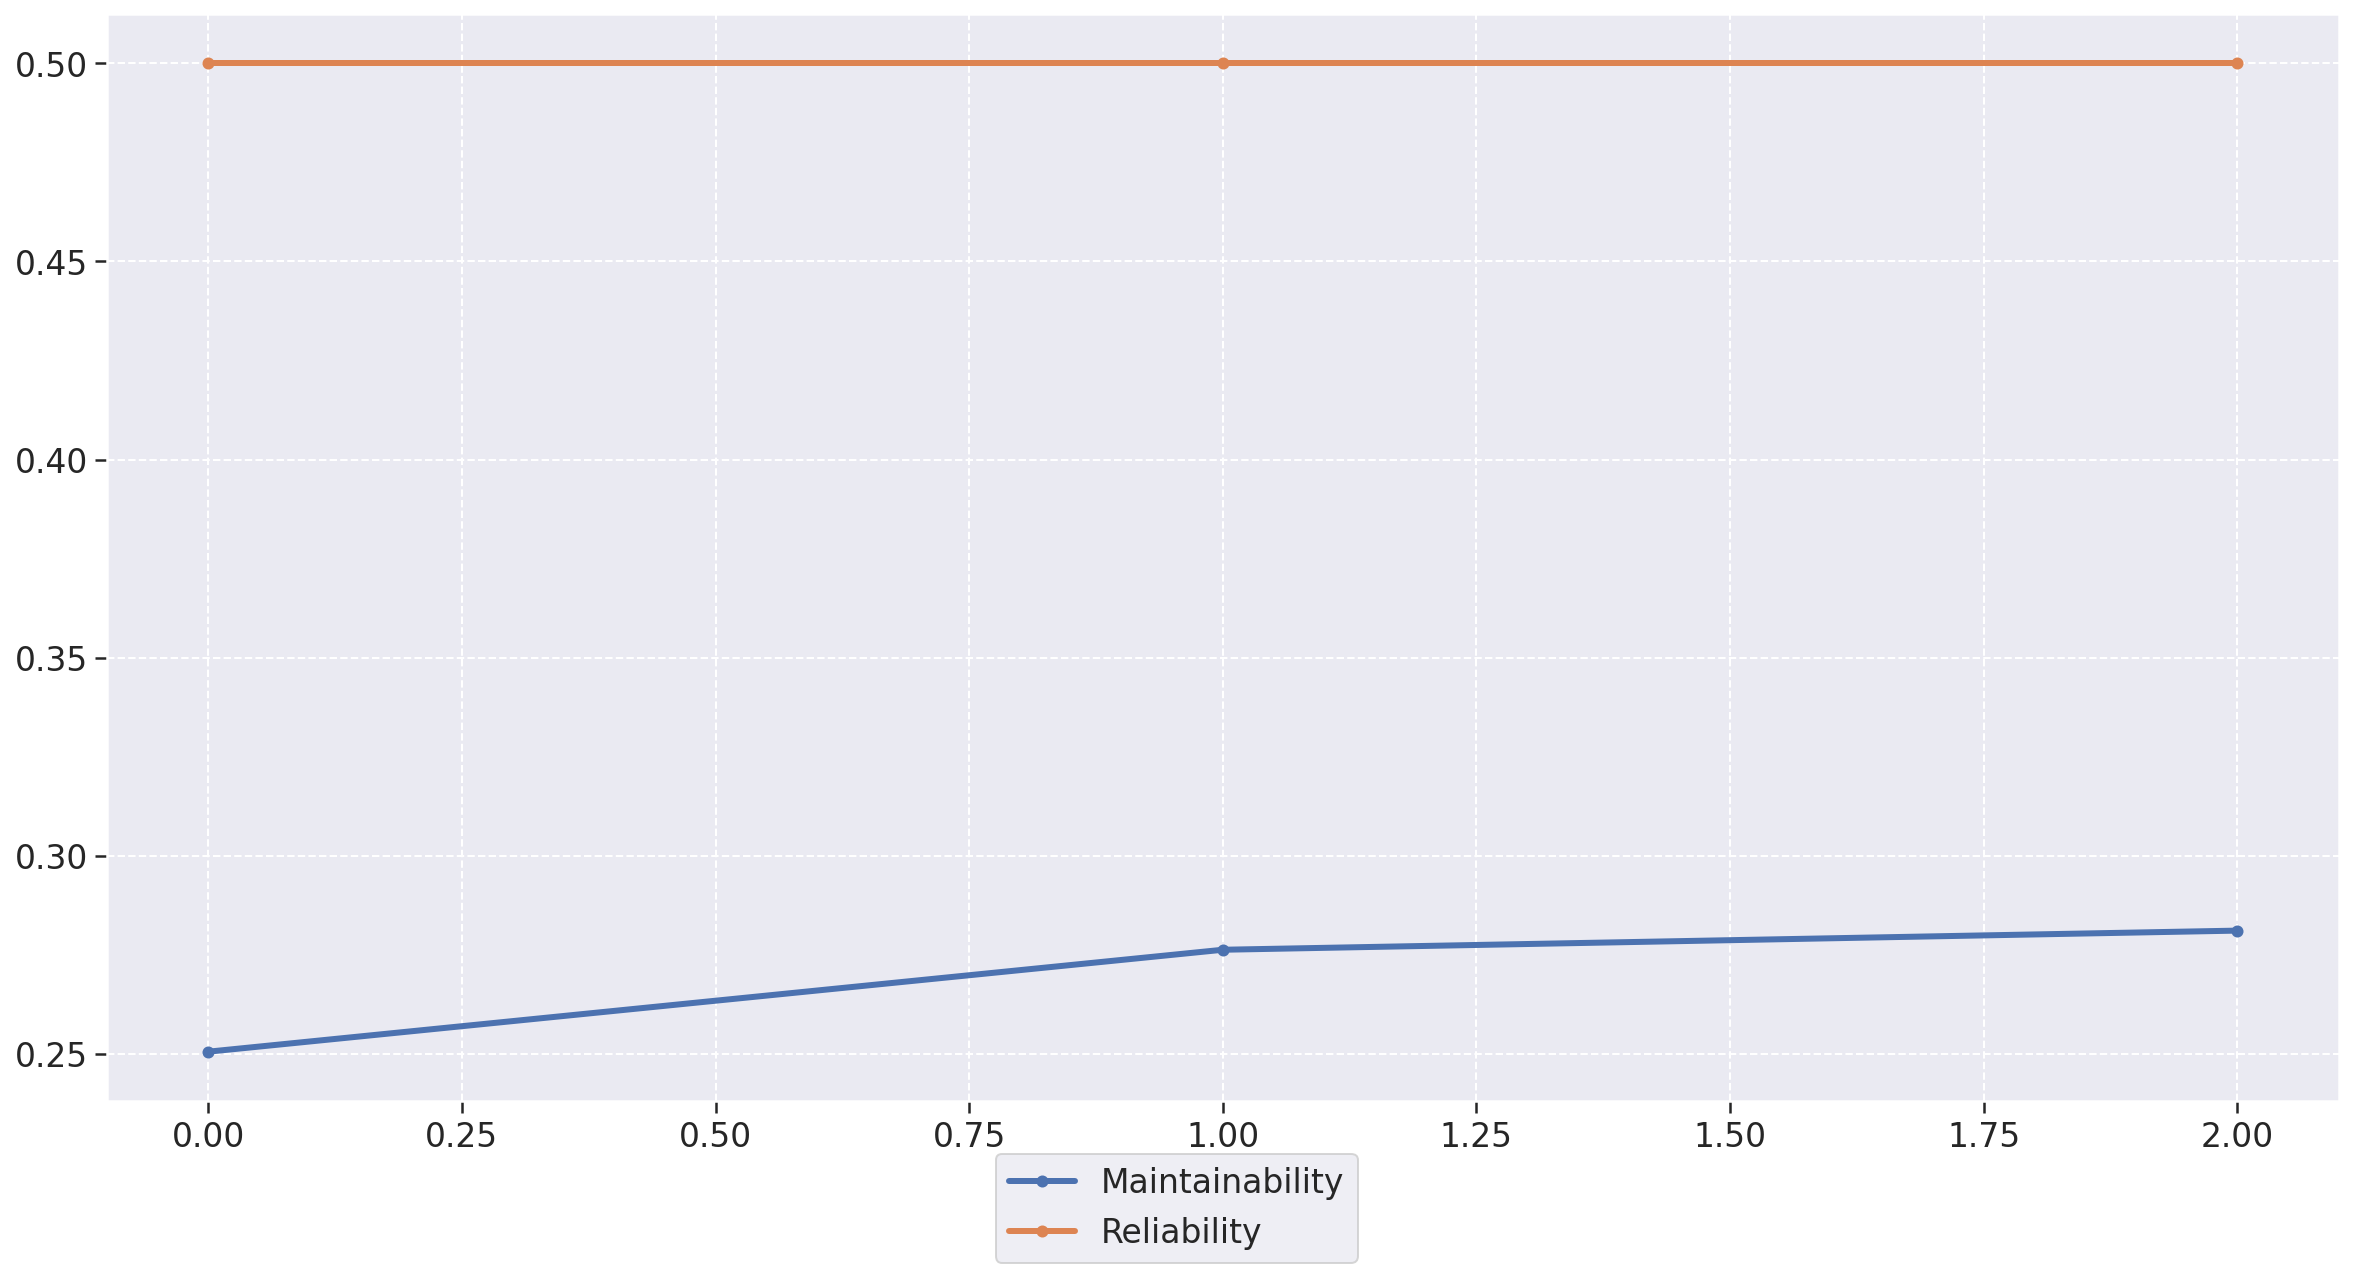

In [37]:
plot_history(generic_df, repository)

### Estatistica descritiva - Admin

In [38]:
descriptive_statistics(generic_df)

/tmp/ipykernel_60612/3699529402.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median = df.median()
/tmp/ipykernel_60612/3699529402.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variance = df.var()


,count,mean,std,min,25%,50%,75%,max,var,median
m1,3.0,0.632214,0.099546,0.518519,0.596469,0.674419,0.689061,0.703704,0.009909,0.674419
m2,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
m3,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
m4,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
m5,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
m6,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
ncloc,3.0,693.666667,364.711301,322.000000,515.000000,708.000000,879.500000,1051.000000,133014.333333,708.000000
code_quality,3.0,0.538630,0.032850,0.501111,0.526835,0.552558,0.557390,0.562222,0.001079,0.552558
testing_status,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
Maintainability,3.0,0.269315,0.016425,0.250556,0.263417,0.276279,0.278695,0.281111,0.000270,0.276279


### Cálculo da moda - Admin

In [39]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.518519,0.0,1.0,1.0,1.0,1.0,322,0.501111,1.0,0.250556,0.5,0.750556
1,0.674419,NaN,NaN,NaN,NaN,NaN,708,0.552558,NaN,0.276279,NaN,0.776279
2,0.703704,NaN,NaN,NaN,NaN,NaN,1051,0.562222,NaN,0.281111,NaN,0.781111


### Tabela de porcentagem - Admin

In [40]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0%,0.518519,0.0,1.0,1.0,1.0,1.0,322.00,0.501111,1.0,0.250556,0.5,0.750556
10%,0.549699,0.0,1.0,1.0,1.0,1.0,399.20,0.511401,1.0,0.255700,0.5,0.755700
20%,0.580879,0.0,1.0,1.0,1.0,1.0,476.40,0.521690,1.0,0.260845,0.5,0.760845
30%,0.612059,0.0,1.0,1.0,1.0,1.0,553.60,0.531979,1.0,0.265990,0.5,0.765990
40%,0.643239,0.0,1.0,1.0,1.0,1.0,630.80,0.542269,1.0,0.271134,0.5,0.771134
50%,0.674419,0.0,1.0,1.0,1.0,1.0,708.00,0.552558,1.0,0.276279,0.5,0.776279
60%,0.680276,0.0,1.0,1.0,1.0,1.0,776.60,0.554491,1.0,0.277245,0.5,0.777245
70%,0.686133,0.0,1.0,1.0,1.0,1.0,845.20,0.556424,1.0,0.278212,0.5,0.778212
80%,0.691990,0.0,1.0,1.0,1.0,1.0,913.80,0.558357,1.0,0.279178,0.5,0.779178
99%,0.703118,0.0,1.0,1.0,1.0,1.0,1044.14,0.562029,1.0,0.281014,0.5,0.781014


### Matriz de correlação - Admin

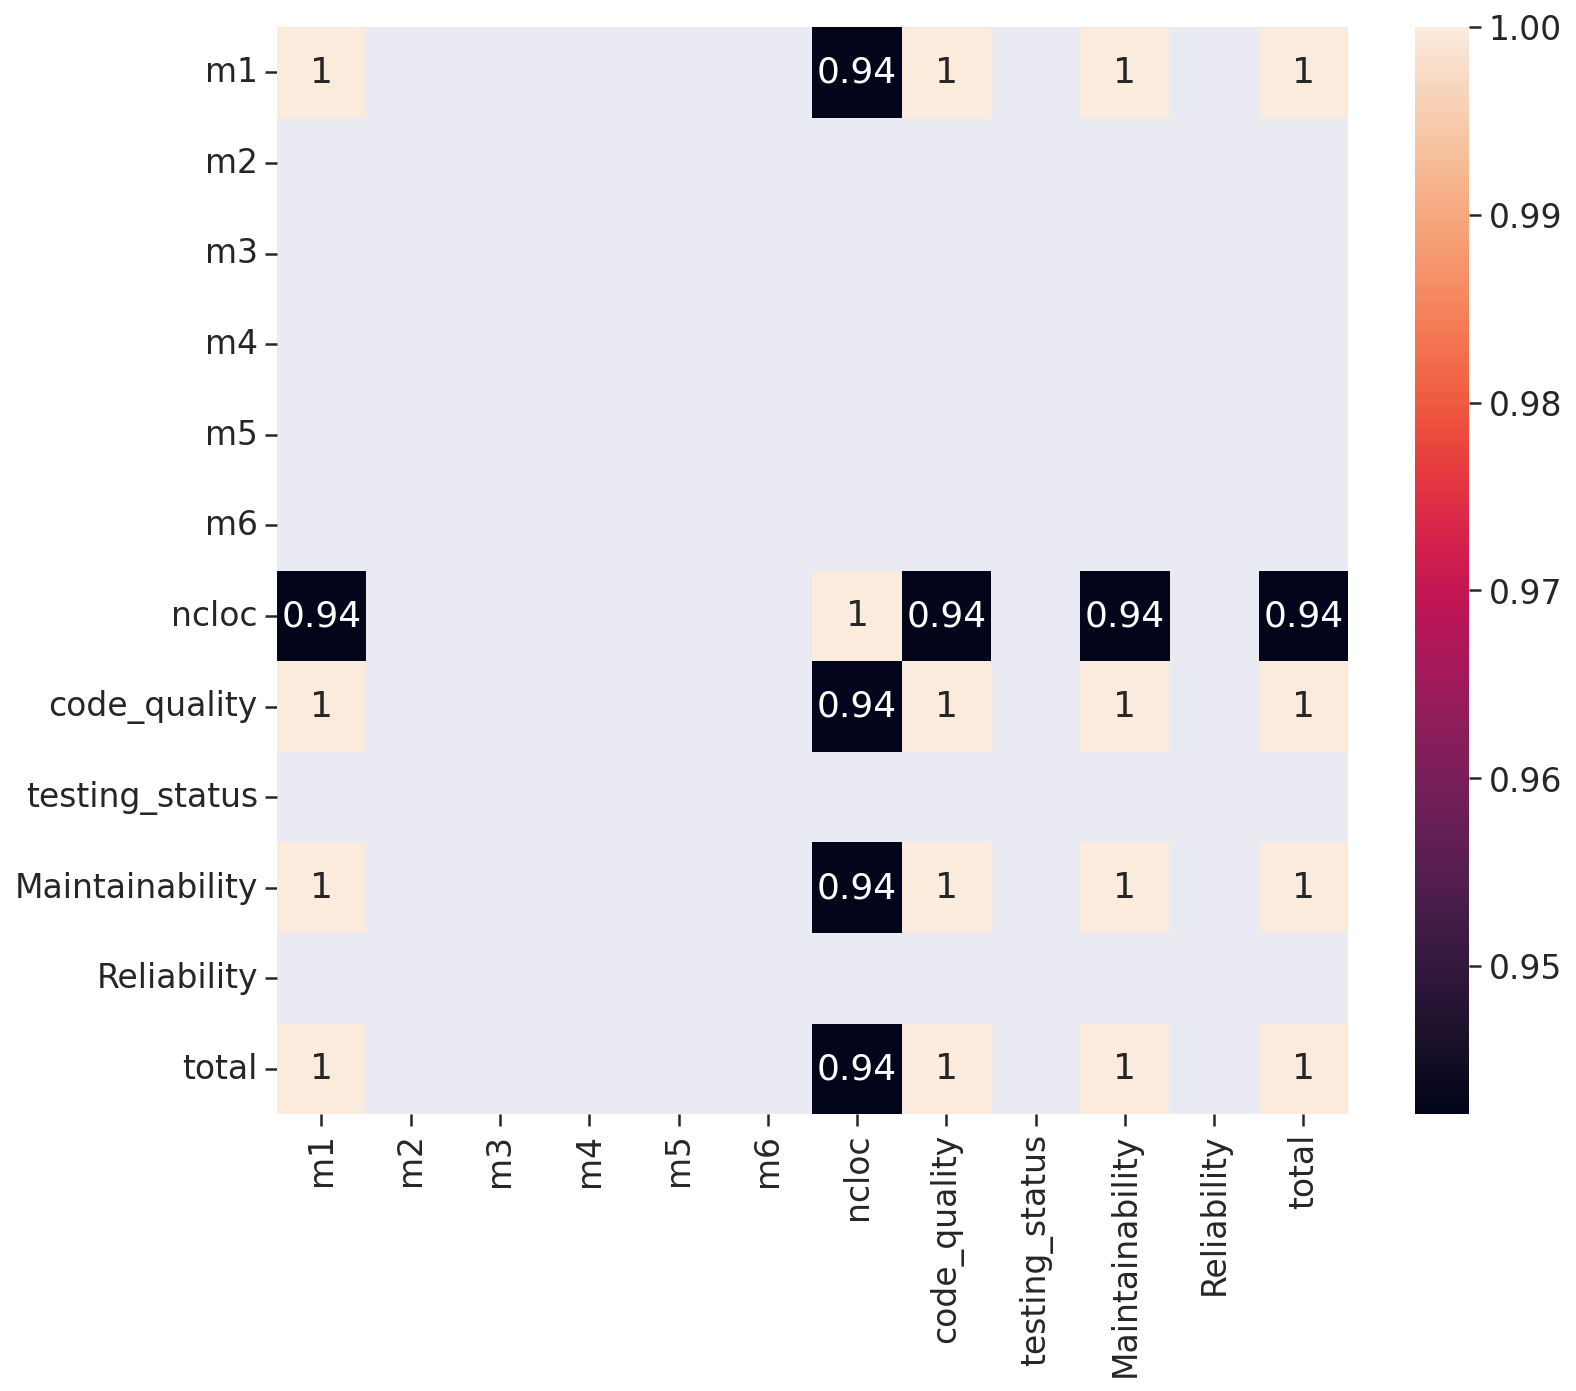

In [41]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Boxplot - Admin

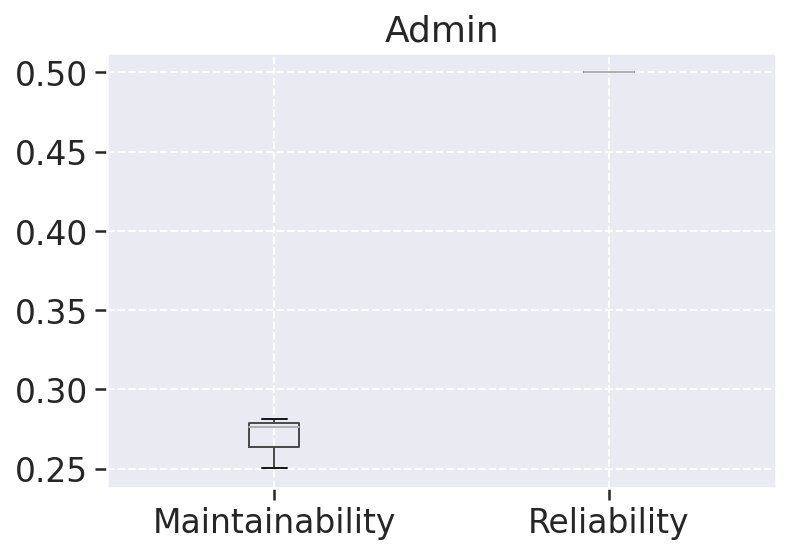

In [42]:
generate_box(generic_df, repository)
#generic_df

## Análise de  [Maintainability e Reliability] do repositório 2021_1-Multilind_User

In [43]:
generic_df = user_metrics_df.sort_values('version')
repository = "User"
generic_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
3,0.625,0.0,1.000000,1.000000,1.000000,1.000000,User,2021-09-14-03:28,70,0.536250,1.000000,0.268125,0.500000,0.768125
4,0.625,0.0,1.000000,1.000000,1.000000,1.000000,User,2021-09-27-02.31,70,0.536250,1.000000,0.268125,0.500000,0.768125
5,0.500,0.0,0.928571,0.928571,0.928571,0.928571,User,2021-10-24-19.18,685,0.471429,0.928571,0.235714,0.464286,0.700000
6,0.500,0.0,0.928571,0.928571,0.928571,0.928571,User,2021-11-03-22:59,688,0.471429,0.928571,0.235714,0.464286,0.700000


### Plot do Histórico das métricas - User

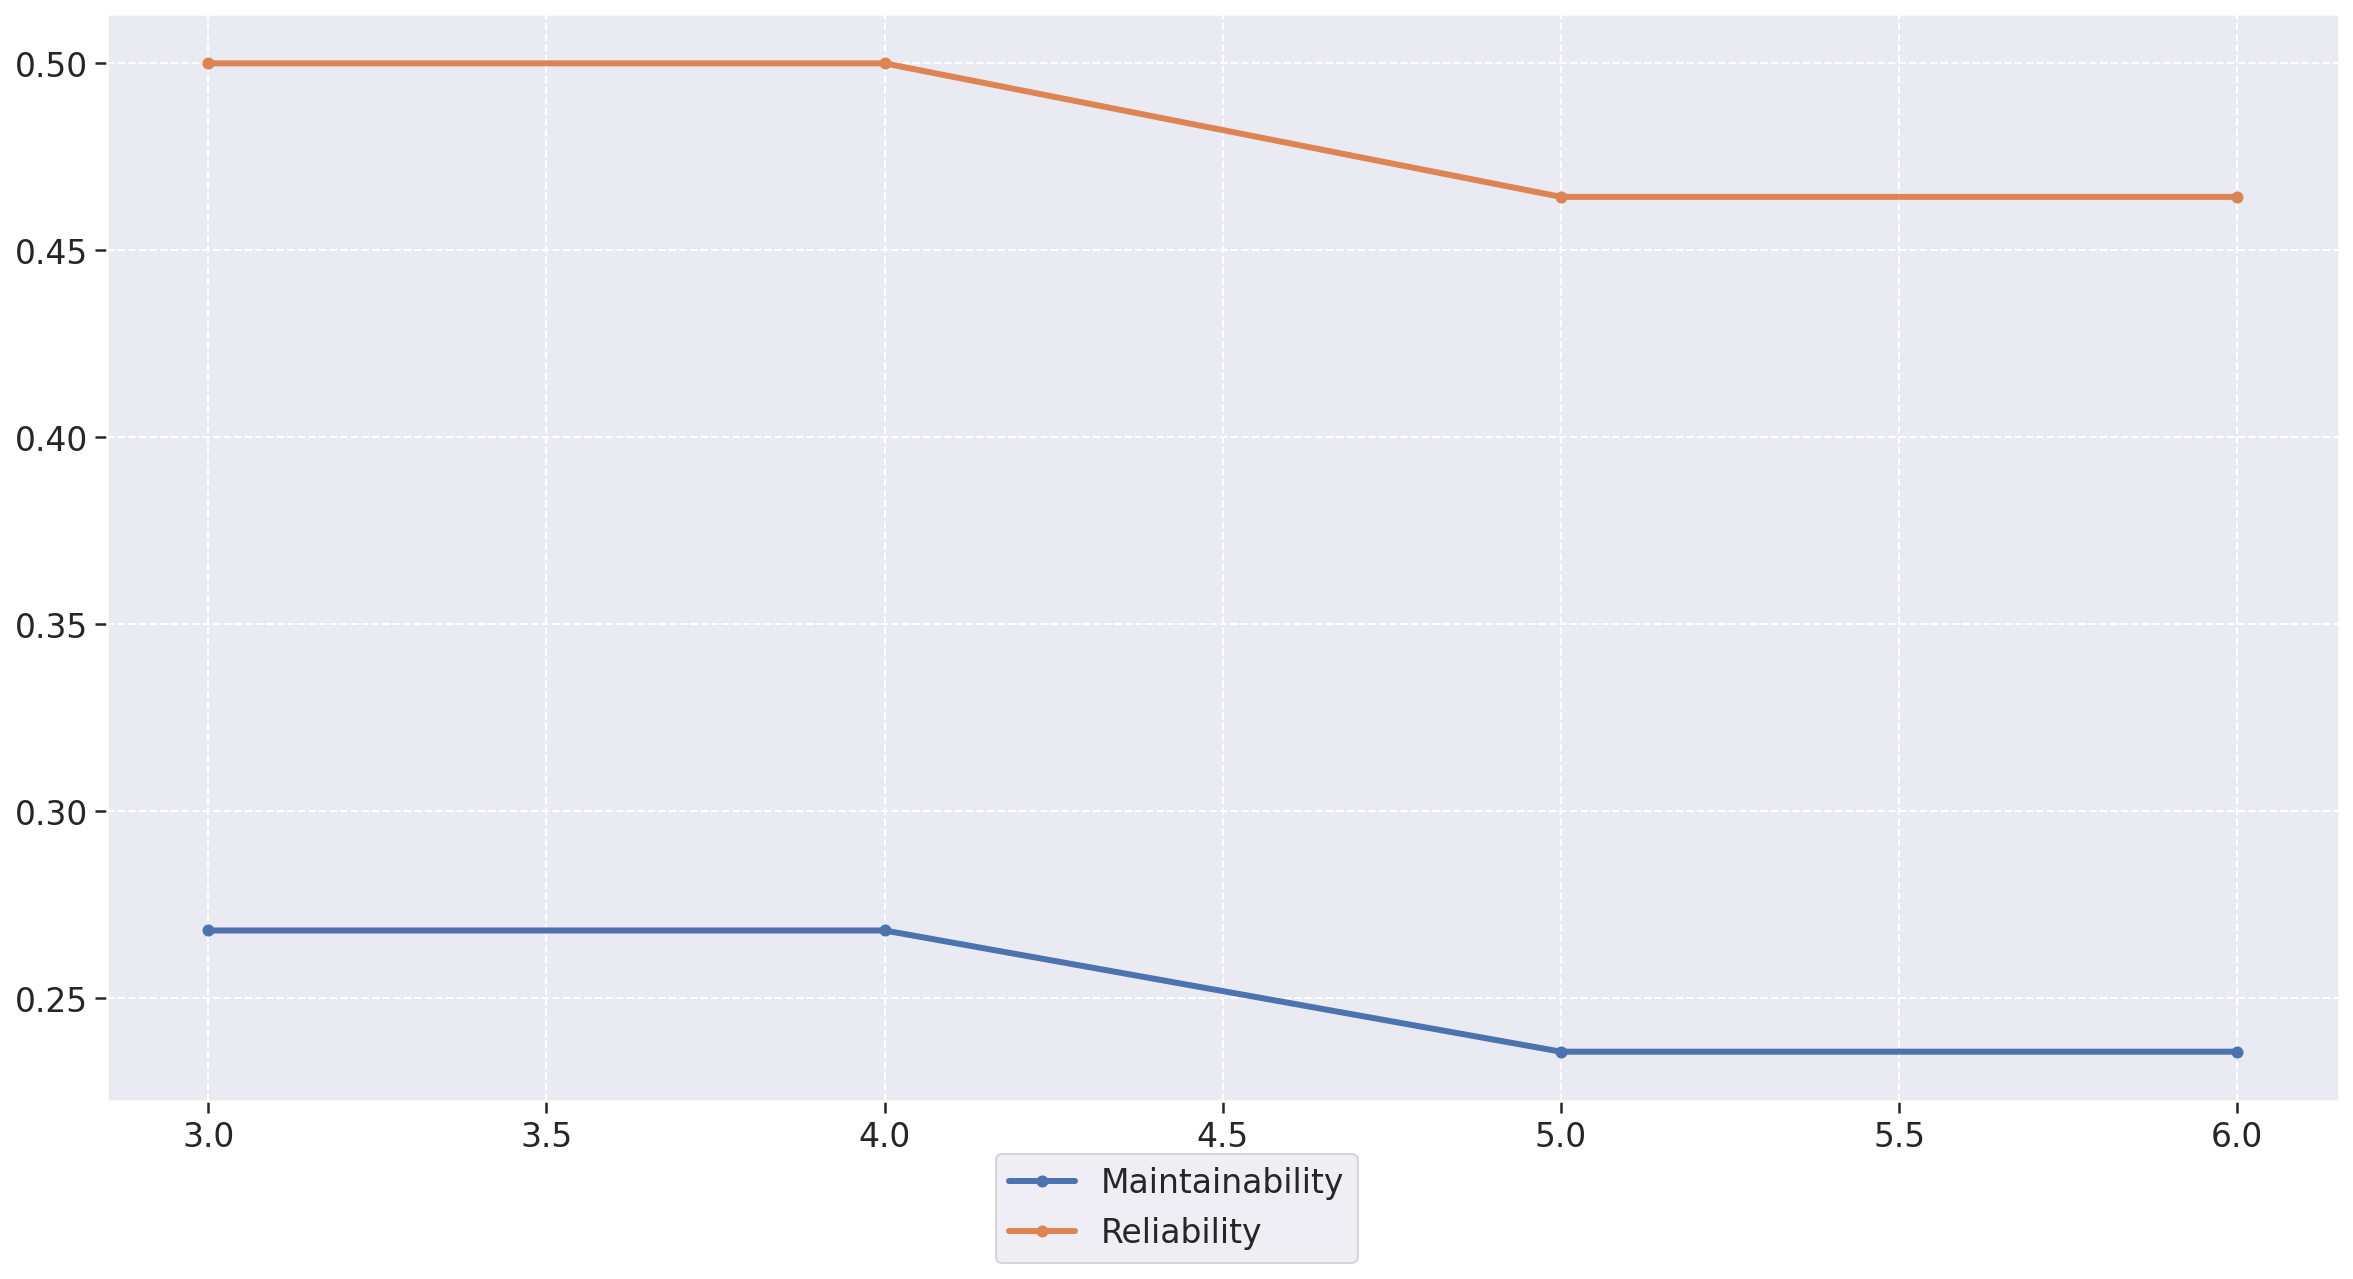

In [44]:
plot_history(generic_df, repository)

### Estatistica descritiva - User

In [45]:
descriptive_statistics(generic_df)

/tmp/ipykernel_60612/3699529402.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median = df.median()
/tmp/ipykernel_60612/3699529402.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variance = df.var()


,count,mean,std,min,25%,50%,75%,max,var,median
m1,4.0,0.562500,0.072169,0.500000,0.500000,0.562500,0.625000,0.625000,0.005208,0.562500
m2,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
m3,4.0,0.964286,0.041239,0.928571,0.928571,0.964286,1.000000,1.000000,0.001701,0.964286
m4,4.0,0.964286,0.041239,0.928571,0.928571,0.964286,1.000000,1.000000,0.001701,0.964286
m5,4.0,0.964286,0.041239,0.928571,0.928571,0.964286,1.000000,1.000000,0.001701,0.964286
m6,4.0,0.964286,0.041239,0.928571,0.928571,0.964286,1.000000,1.000000,0.001701,0.964286
ncloc,4.0,378.250000,355.938548,70.000000,70.000000,377.500000,685.750000,688.000000,126692.250000,377.500000
code_quality,4.0,0.503839,0.037425,0.471429,0.471429,0.503839,0.536250,0.536250,0.001401,0.503839
testing_status,4.0,0.964286,0.041239,0.928571,0.928571,0.964286,1.000000,1.000000,0.001701,0.964286
Maintainability,4.0,0.251920,0.018712,0.235714,0.235714,0.251920,0.268125,0.268125,0.000350,0.251920


### Cálculo da moda - User

In [46]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.500,0.0,0.928571,0.928571,0.928571,0.928571,70.0,0.471429,0.928571,0.235714,0.464286,0.700000
1,0.625,NaN,1.000000,1.000000,1.000000,1.000000,NaN,0.536250,1.000000,0.268125,0.500000,0.768125


### Tabela de porcentagem - User

In [47]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0%,0.5000,0.0,0.928571,0.928571,0.928571,0.928571,70.00,0.471429,0.928571,0.235714,0.464286,0.700000
10%,0.5000,0.0,0.928571,0.928571,0.928571,0.928571,70.00,0.471429,0.928571,0.235714,0.464286,0.700000
20%,0.5000,0.0,0.928571,0.928571,0.928571,0.928571,70.00,0.471429,0.928571,0.235714,0.464286,0.700000
30%,0.5000,0.0,0.928571,0.928571,0.928571,0.928571,70.00,0.471429,0.928571,0.235714,0.464286,0.700000
40%,0.5250,0.0,0.942857,0.942857,0.942857,0.942857,193.00,0.484393,0.942857,0.242196,0.471429,0.713625
50%,0.5625,0.0,0.964286,0.964286,0.964286,0.964286,377.50,0.503839,0.964286,0.251920,0.482143,0.734062
60%,0.6000,0.0,0.985714,0.985714,0.985714,0.985714,562.00,0.523286,0.985714,0.261643,0.492857,0.754500
70%,0.6250,0.0,1.000000,1.000000,1.000000,1.000000,685.30,0.536250,1.000000,0.268125,0.500000,0.768125
80%,0.6250,0.0,1.000000,1.000000,1.000000,1.000000,686.20,0.536250,1.000000,0.268125,0.500000,0.768125
99%,0.6250,0.0,1.000000,1.000000,1.000000,1.000000,687.91,0.536250,1.000000,0.268125,0.500000,0.768125


### Matriz de correlação - User

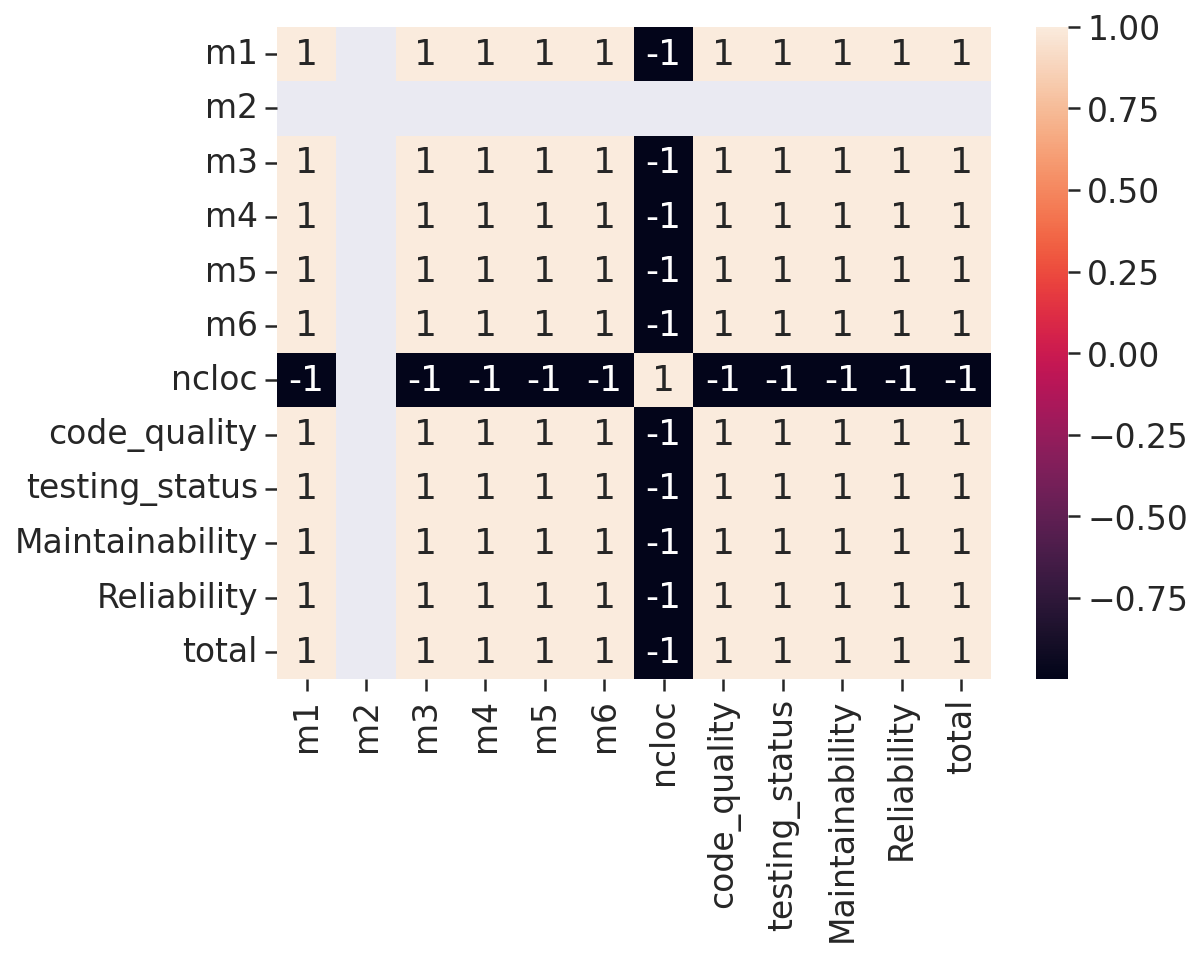

In [48]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Boxplot - User

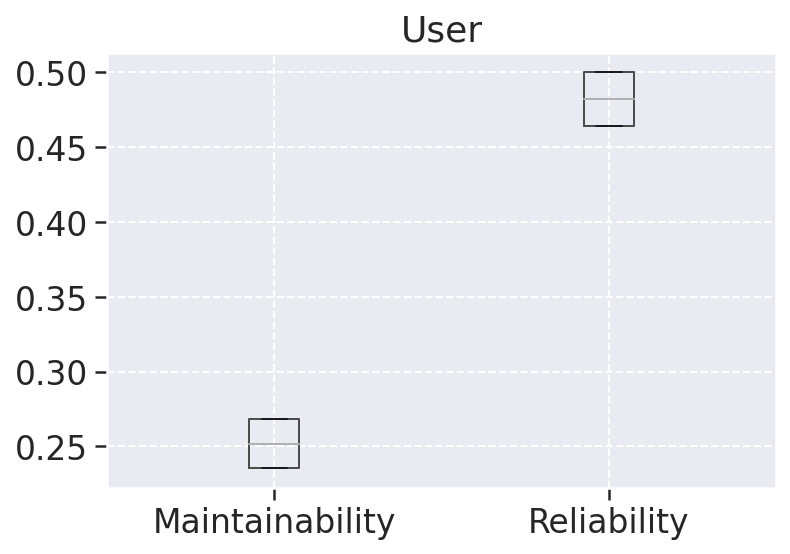

In [49]:
generate_box(generic_df, repository)
#generic_df

## Análise de  [Maintainability e Reliability] do repositório 2021_1-Multilind_Content

In [50]:
generic_df = content_metrics_df.sort_values('version')
repository = "Content"
generic_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
7,0.714286,0.000000,0.892857,0.892857,0.892857,0.892857,Content,2021-09-14-03:28,629,0.530357,0.892857,0.265179,0.446429,0.711607
8,0.711538,0.000000,0.942308,0.942308,0.942308,0.942308,Content,2021-09-27-03.22,1323,0.545769,0.942308,0.272885,0.471154,0.744038
9,0.723077,0.000000,0.969231,0.969231,0.969231,0.969231,Content,2021-10-06-19.24,1879,0.558462,0.969231,0.279231,0.484615,0.763846
10,0.697917,0.000000,0.979167,0.979167,0.979167,0.979167,Content,2021-10-19-18.48,2477,0.553438,0.979167,0.276719,0.489583,0.766302
11,0.710000,0.000000,0.980000,0.980000,0.980000,0.980000,Content,2021-11-03-22:59,2647,0.557700,0.980000,0.278850,0.490000,0.768850
12,0.703297,0.021978,0.978022,0.978022,0.978022,0.978022,Content,2021-11-10-17.00,2038,0.562088,0.978022,0.281044,0.489011,0.770055


### Plot do Histórico das métricas - Content

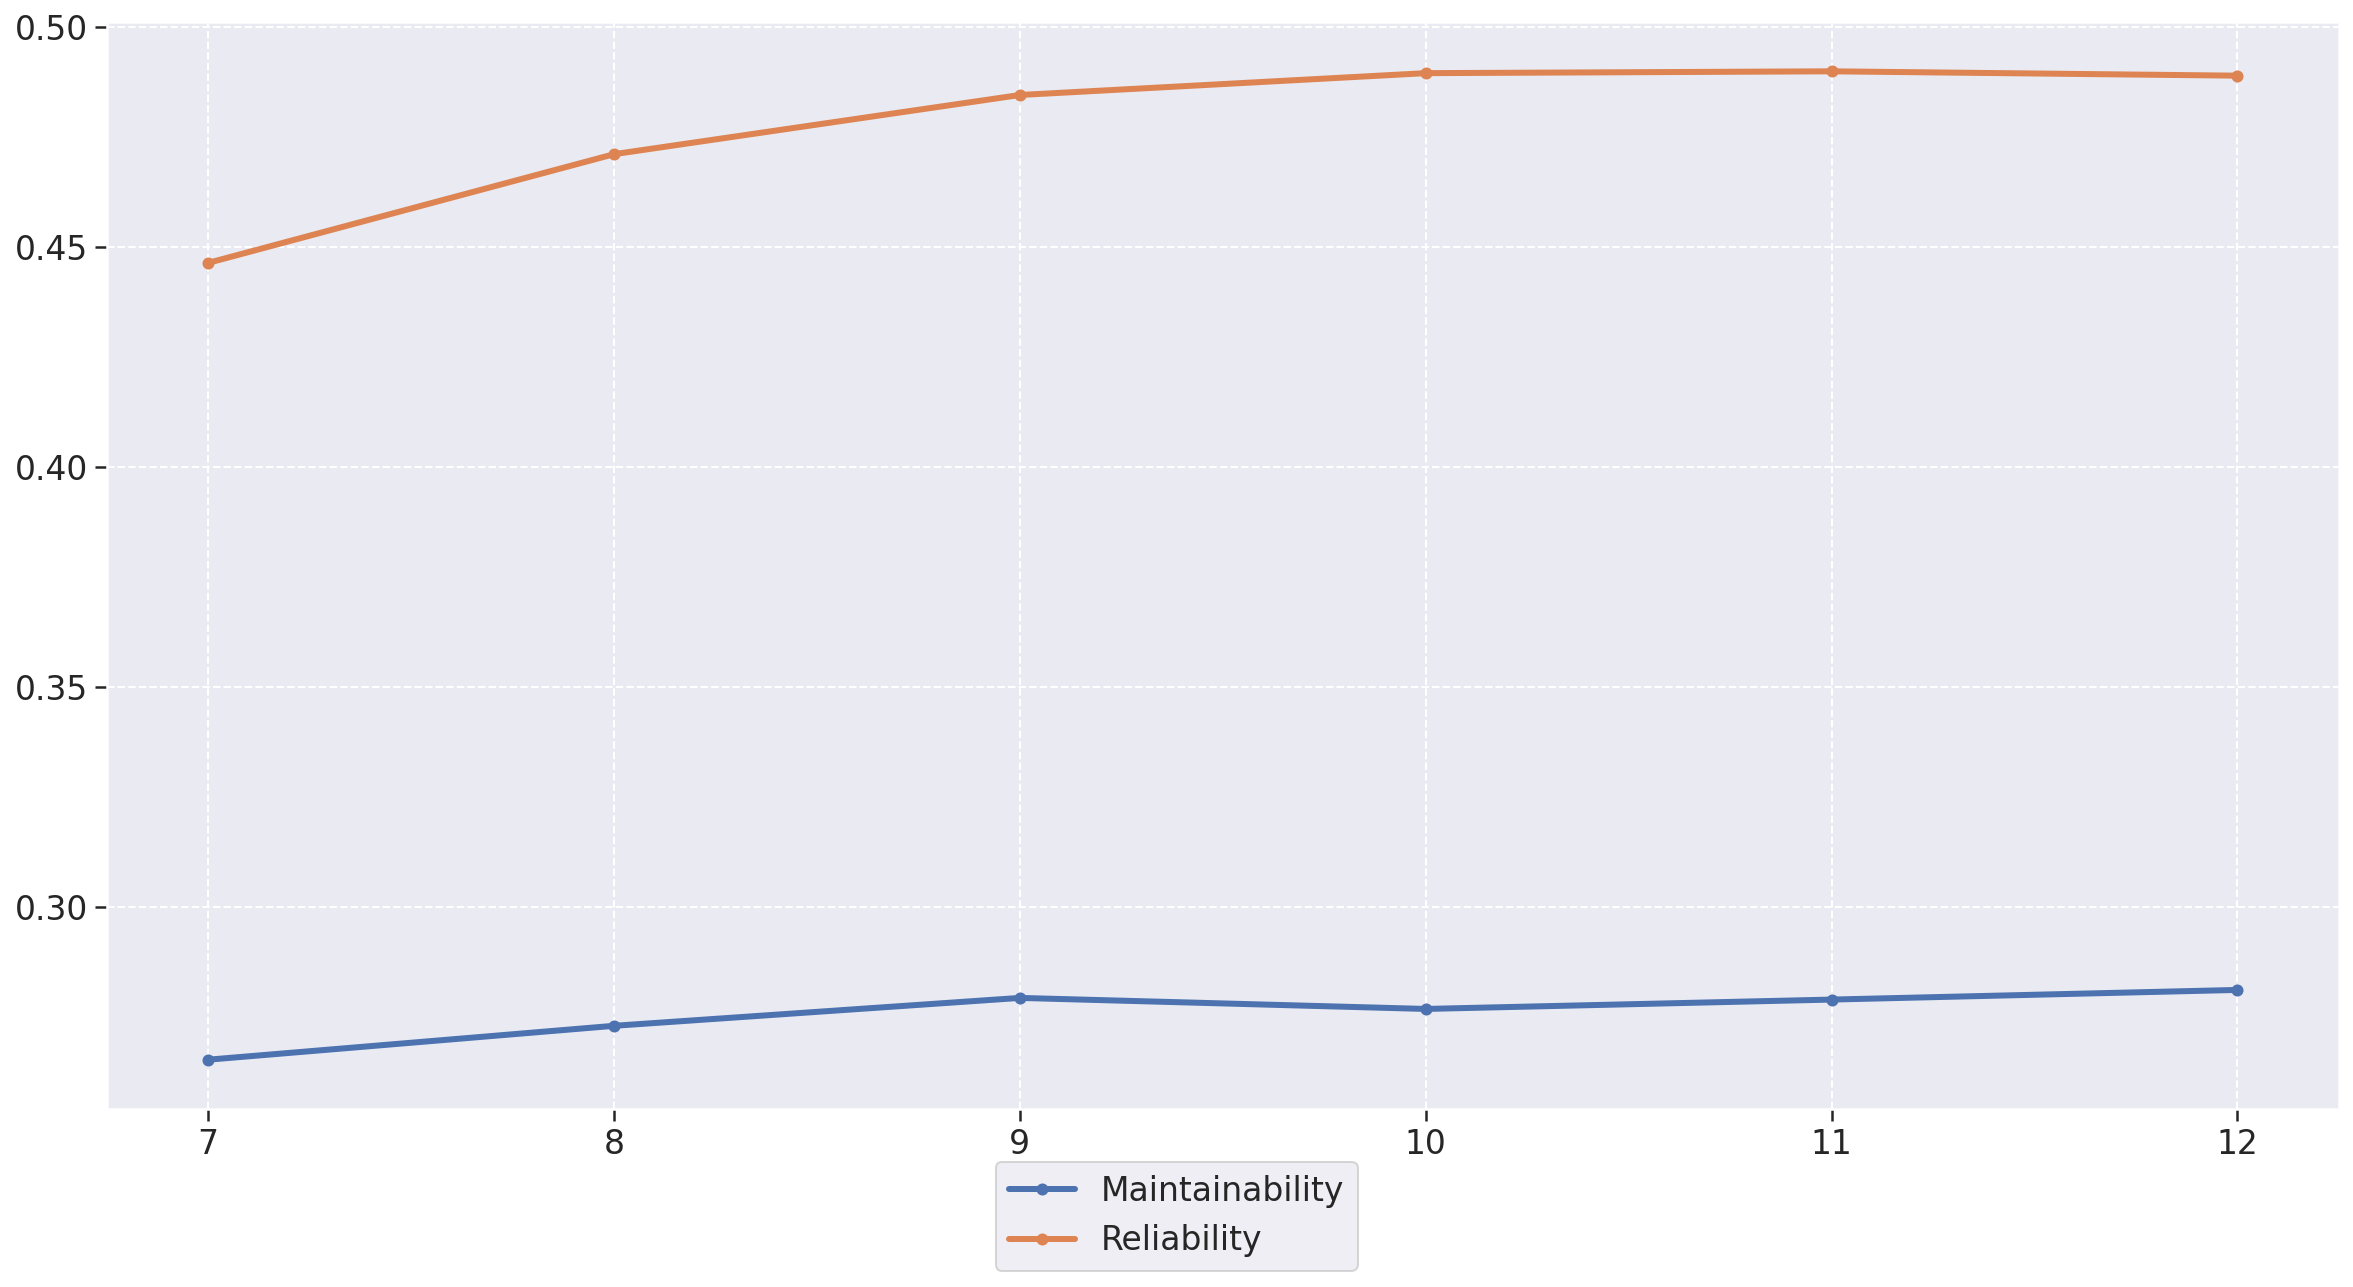

In [51]:
plot_history(generic_df, repository)

### Estatistica descritiva - Content

In [52]:
descriptive_statistics(generic_df)

/tmp/ipykernel_60612/3699529402.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median = df.median()
/tmp/ipykernel_60612/3699529402.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variance = df.var()


,count,mean,std,min,25%,50%,75%,max,var,median
m1,6.0,0.710019,0.008748,0.697917,0.704973,0.710769,0.713599,0.723077,0.000077,0.710769
m2,6.0,0.003663,0.008972,0.000000,0.000000,0.000000,0.000000,0.021978,0.000081,0.000000
m3,6.0,0.956931,0.034473,0.892857,0.949038,0.973626,0.978880,0.980000,0.001188,0.973626
m4,6.0,0.956931,0.034473,0.892857,0.949038,0.973626,0.978880,0.980000,0.001188,0.973626
m5,6.0,0.956931,0.034473,0.892857,0.949038,0.973626,0.978880,0.980000,0.001188,0.973626
m6,6.0,0.956931,0.034473,0.892857,0.949038,0.973626,0.978880,0.980000,0.001188,0.973626
ncloc,6.0,1832.166667,752.487187,629.000000,1462.000000,1958.500000,2367.250000,2647.000000,566236.966667,1958.500000
code_quality,6.0,0.551302,0.011682,0.530357,0.547686,0.555569,0.558271,0.562088,0.000136,0.555569
testing_status,6.0,0.956931,0.034473,0.892857,0.949038,0.973626,0.978880,0.980000,0.001188,0.973626
Maintainability,6.0,0.275651,0.005841,0.265179,0.273843,0.277784,0.279136,0.281044,0.000034,0.277784


### Cálculo da moda - Content

In [53]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.697917,0.0,0.892857,0.892857,0.892857,0.892857,629,0.530357,0.892857,0.265179,0.446429,0.711607
1,0.703297,NaN,0.942308,0.942308,0.942308,0.942308,1323,0.545769,0.942308,0.272885,0.471154,0.744038
2,0.710000,NaN,0.969231,0.969231,0.969231,0.969231,1879,0.553438,0.969231,0.276719,0.484615,0.763846
3,0.711538,NaN,0.978022,0.978022,0.978022,0.978022,2038,0.557700,0.978022,0.278850,0.489011,0.766302
4,0.714286,NaN,0.979167,0.979167,0.979167,0.979167,2477,0.558462,0.979167,0.279231,0.489583,0.768850
5,0.723077,NaN,0.980000,0.980000,0.980000,0.980000,2647,0.562088,0.980000,0.281044,0.490000,0.770055


### Tabela de porcentagem - Content

In [54]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0%,0.697917,0.000000,0.892857,0.892857,0.892857,0.892857,629.0,0.530357,0.892857,0.265179,0.446429,0.711607
10%,0.700607,0.000000,0.917582,0.917582,0.917582,0.917582,976.0,0.538063,0.917582,0.269032,0.458791,0.727823
20%,0.703297,0.000000,0.942308,0.942308,0.942308,0.942308,1323.0,0.545769,0.942308,0.272885,0.471154,0.744038
30%,0.706648,0.000000,0.955769,0.955769,0.955769,0.955769,1601.0,0.549603,0.955769,0.274802,0.477885,0.753942
40%,0.710000,0.000000,0.969231,0.969231,0.969231,0.969231,1879.0,0.553438,0.969231,0.276719,0.484615,0.763846
50%,0.710769,0.000000,0.973626,0.973626,0.973626,0.973626,1958.5,0.555569,0.973626,0.277784,0.486813,0.765074
60%,0.711538,0.000000,0.978022,0.978022,0.978022,0.978022,2038.0,0.557700,0.978022,0.278850,0.489011,0.766302
70%,0.712912,0.000000,0.978594,0.978594,0.978594,0.978594,2257.5,0.558081,0.978594,0.279040,0.489297,0.767576
80%,0.714286,0.000000,0.979167,0.979167,0.979167,0.979167,2477.0,0.558462,0.979167,0.279231,0.489583,0.768850
99%,0.722637,0.020879,0.979958,0.979958,0.979958,0.979958,2638.5,0.561907,0.979958,0.280953,0.489979,0.769995


### Matriz de correlação - Content

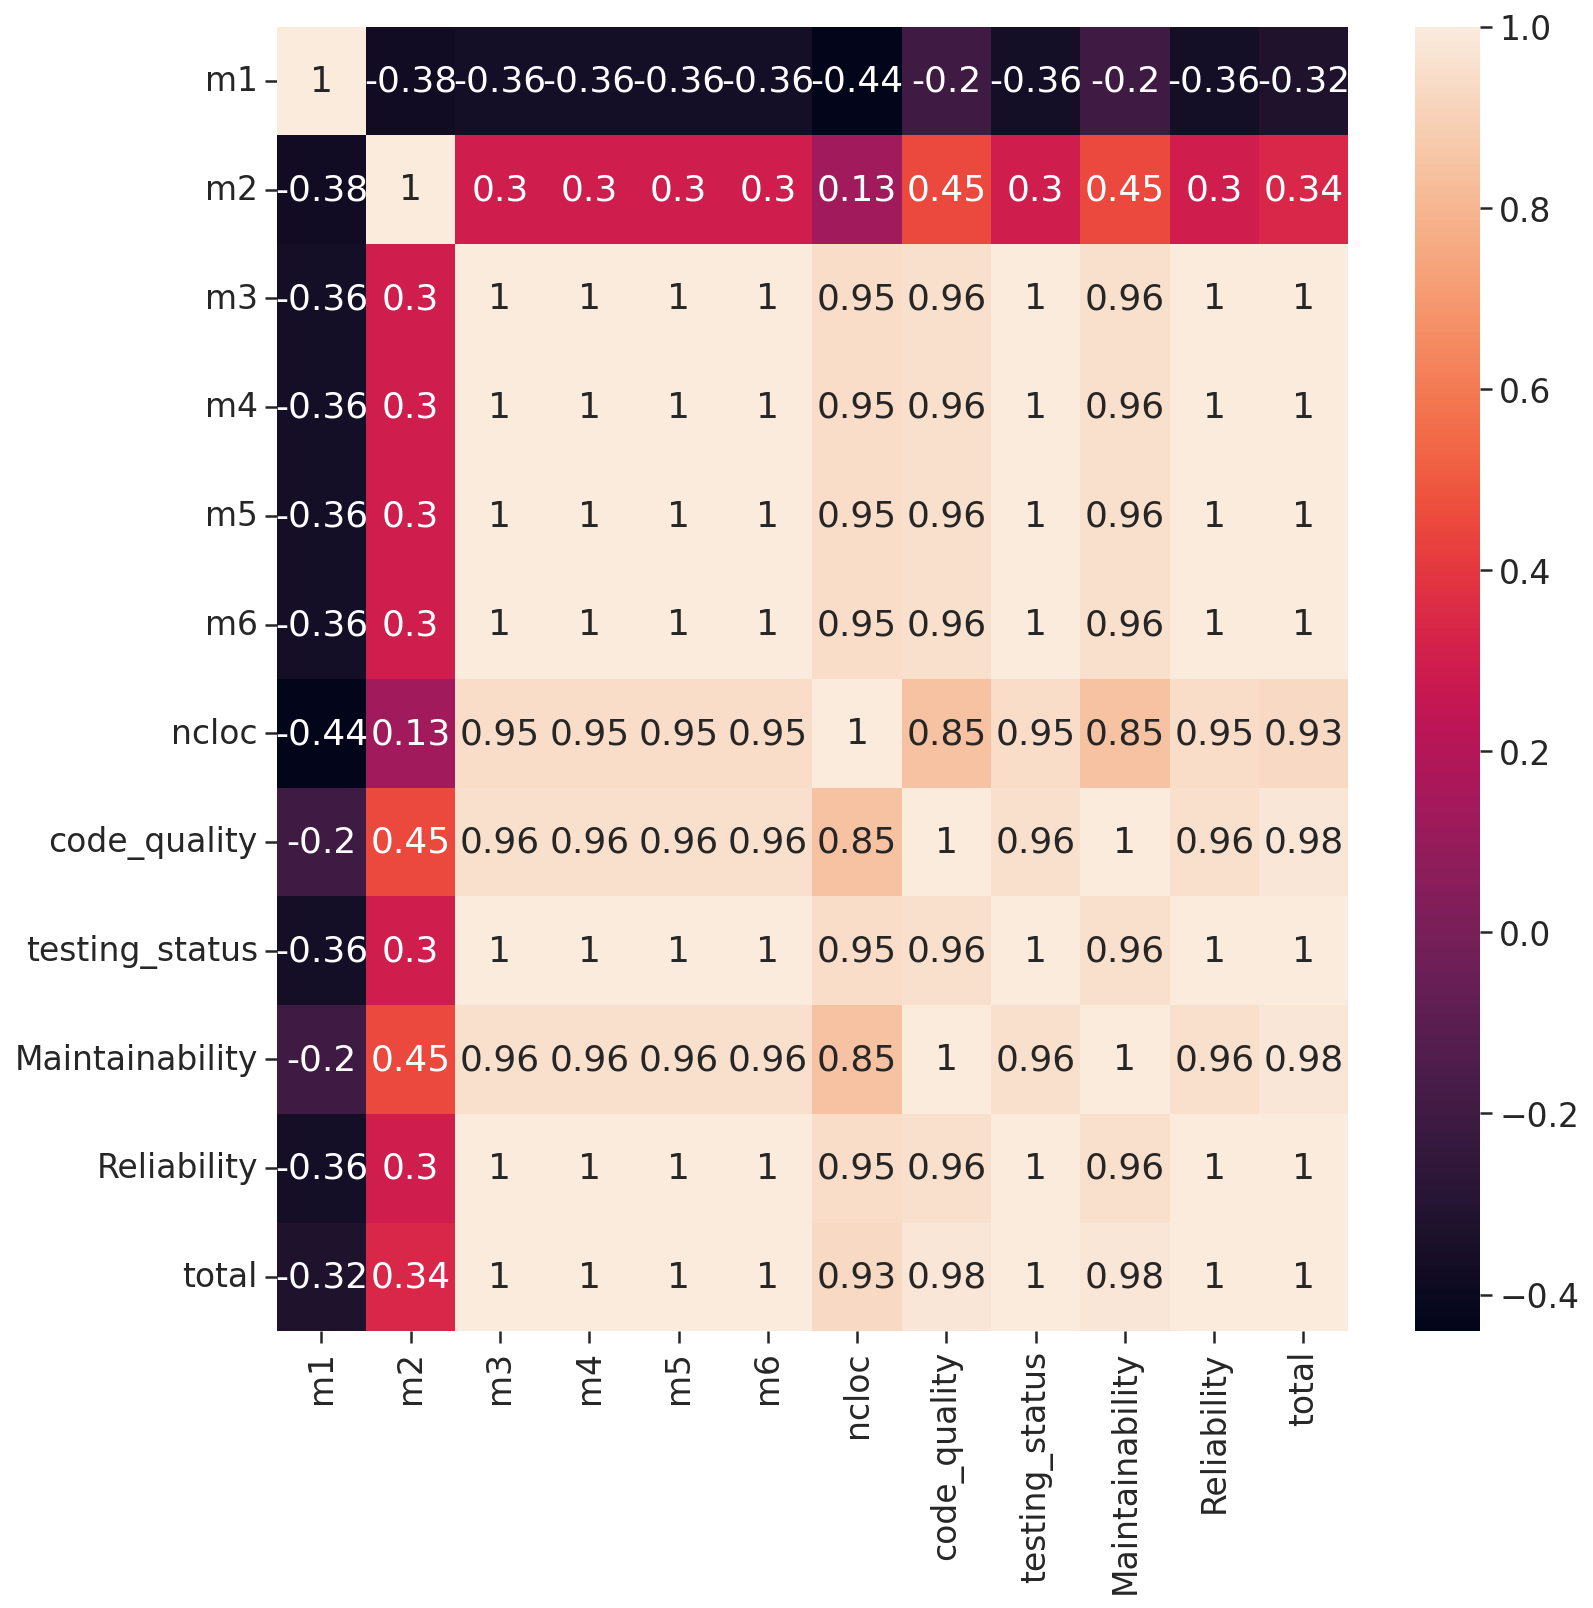

In [55]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(12, 12))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Boxplot - Content

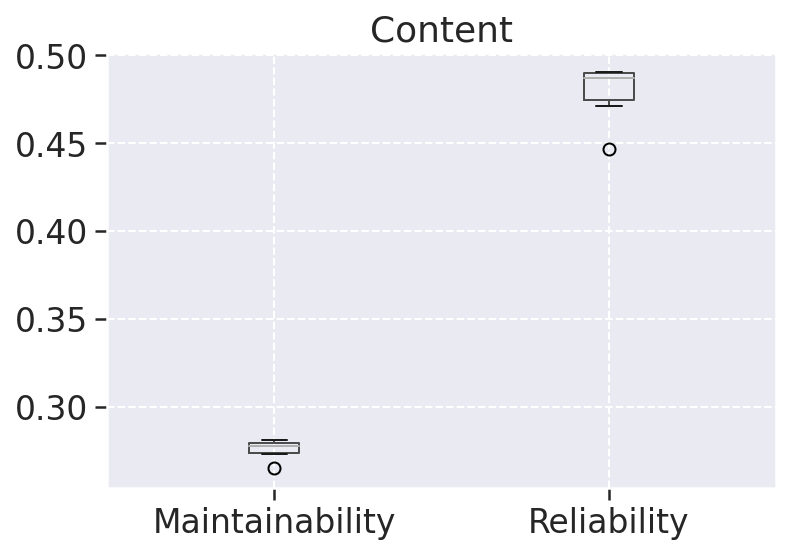

In [56]:
generate_box(generic_df, repository)
#generic_df

## Análise de  [Maintainability e Reliability] do repositório 2021_1-Multilind_Files

In [57]:
generic_df = files_metrics_df.sort_values('version')
repository = "Files"
generic_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
13,0.571429,0.0,1.0,1.0,1.0,1.0,Files,2021-09-14-03:28,54,0.518571,1.0,0.259286,0.5,0.759286
14,0.500000,0.0,1.0,1.0,1.0,1.0,Files,2021-10-15-19.42,125,0.495000,1.0,0.247500,0.5,0.747500
15,0.500000,0.0,1.0,1.0,1.0,1.0,Files,2021-10-15-20.05,125,0.495000,1.0,0.247500,0.5,0.747500
16,0.500000,0.0,1.0,1.0,1.0,1.0,Files,2021-11-03-22:59,132,0.495000,1.0,0.247500,0.5,0.747500


### Plot do Histórico das métricas - Files

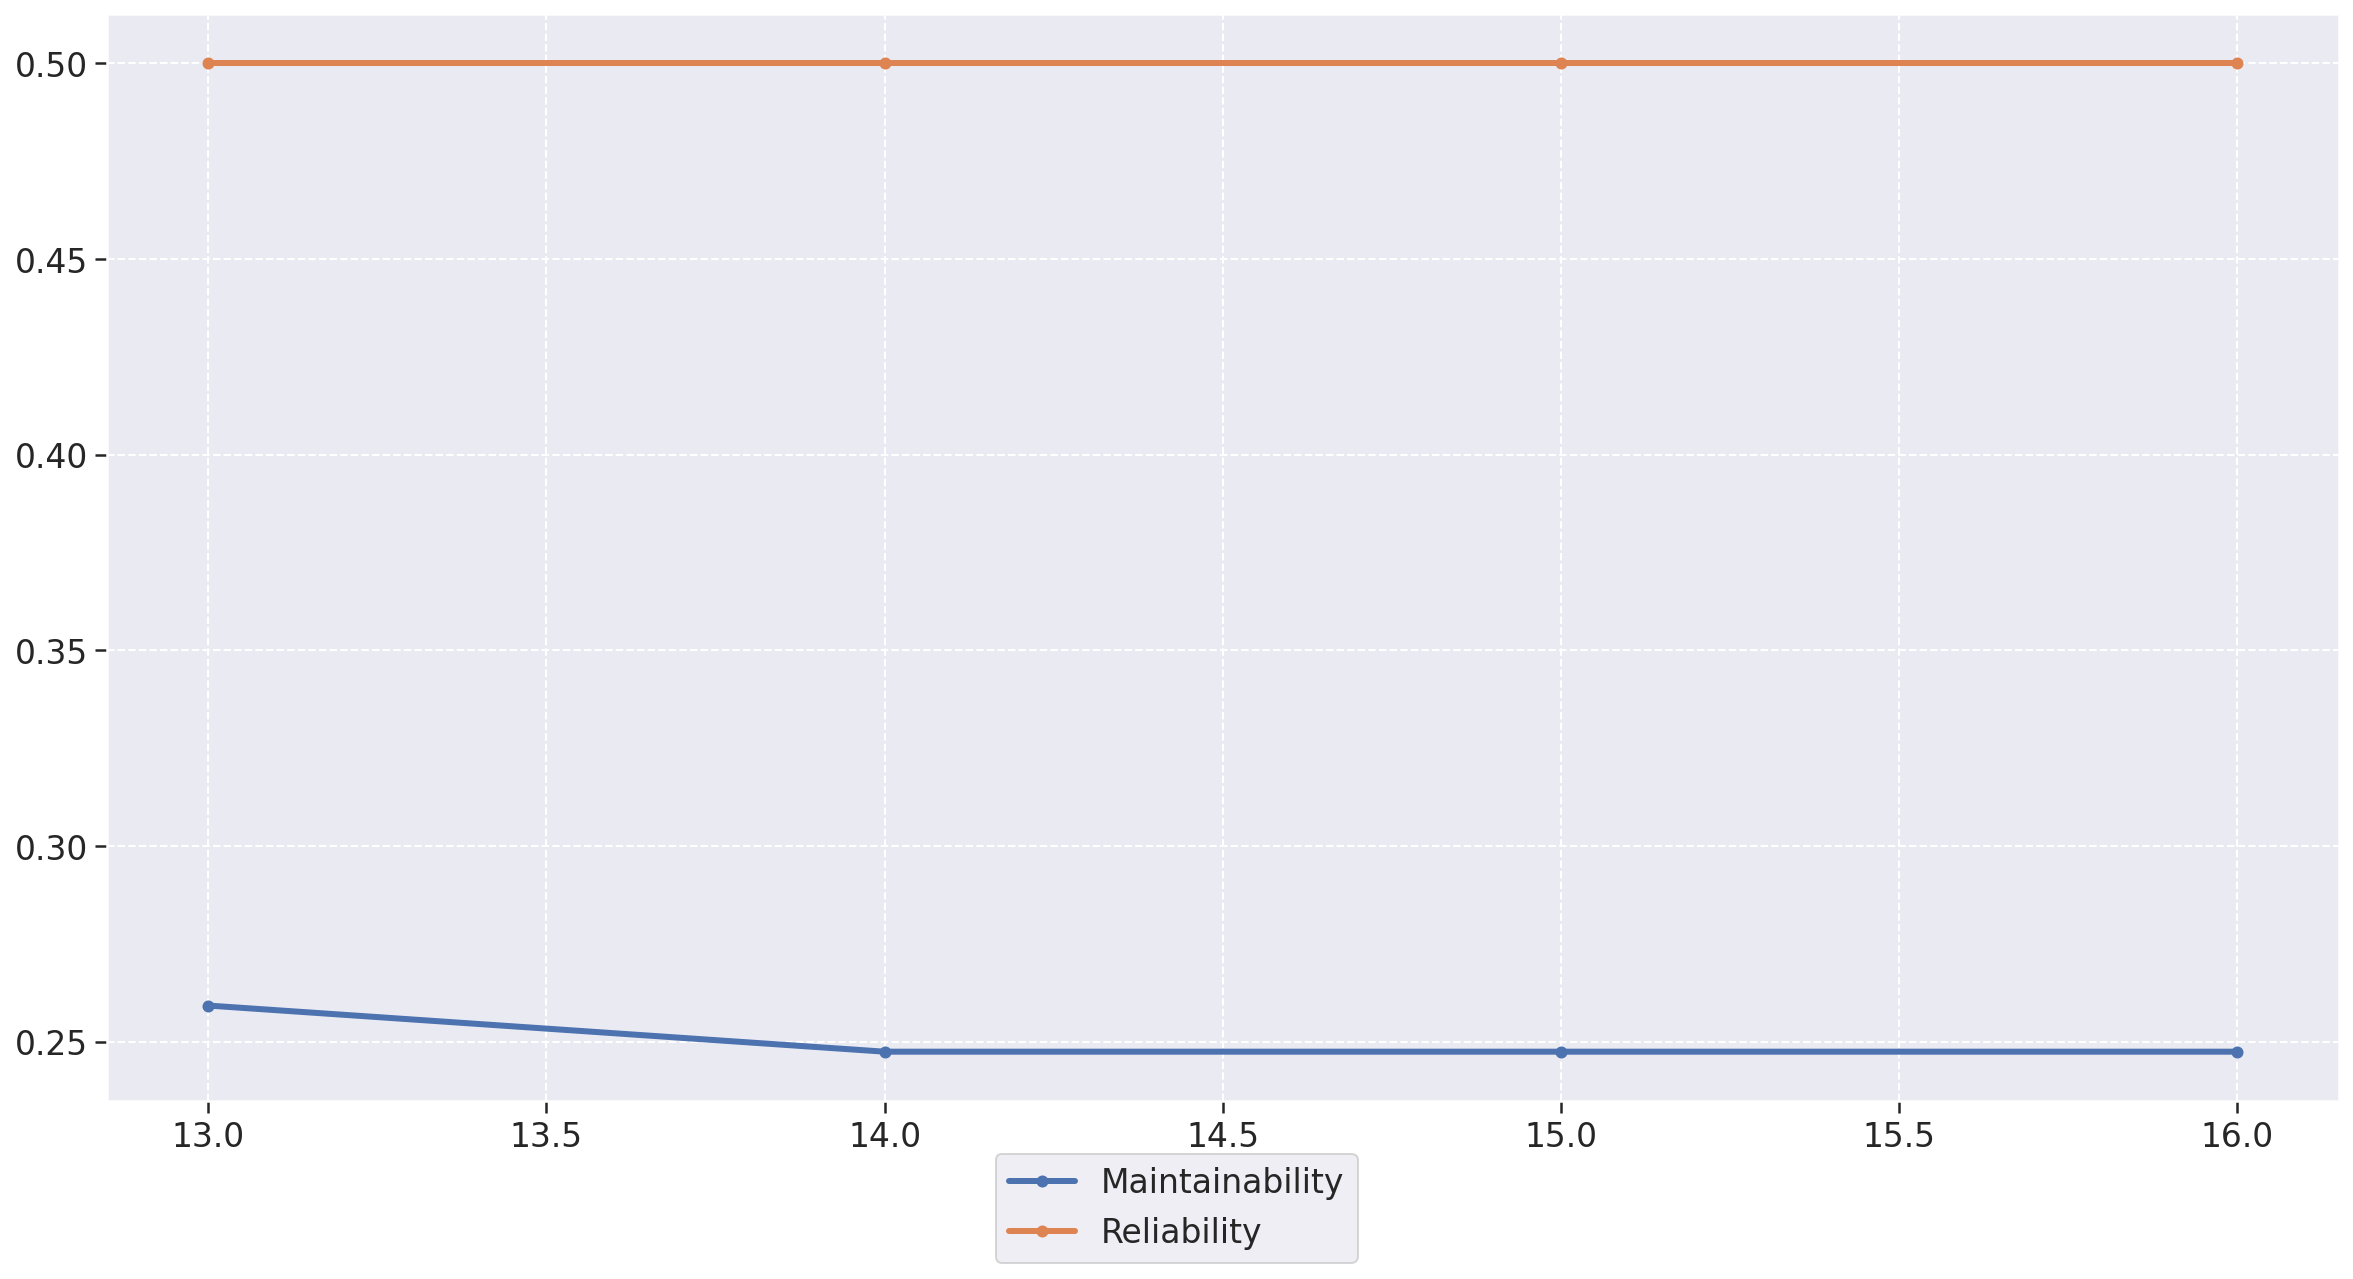

In [58]:
plot_history(generic_df, repository)

### Estatistica descritiva - Files

In [59]:
descriptive_statistics(generic_df)

/tmp/ipykernel_60612/3699529402.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median = df.median()
/tmp/ipykernel_60612/3699529402.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variance = df.var()


,count,mean,std,min,25%,50%,75%,max,var,median
m1,4.0,0.517857,0.035714,0.5000,0.5000,0.5000,0.517857,0.571429,0.001276,0.5000
m2,4.0,0.000000,0.000000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000
m3,4.0,1.000000,0.000000,1.0000,1.0000,1.0000,1.000000,1.000000,0.000000,1.0000
m4,4.0,1.000000,0.000000,1.0000,1.0000,1.0000,1.000000,1.000000,0.000000,1.0000
m5,4.0,1.000000,0.000000,1.0000,1.0000,1.0000,1.000000,1.000000,0.000000,1.0000
m6,4.0,1.000000,0.000000,1.0000,1.0000,1.0000,1.000000,1.000000,0.000000,1.0000
ncloc,4.0,109.000000,36.814852,54.0000,107.2500,125.0000,126.750000,132.000000,1355.333333,125.0000
code_quality,4.0,0.500893,0.011786,0.4950,0.4950,0.4950,0.500893,0.518571,0.000139,0.4950
testing_status,4.0,1.000000,0.000000,1.0000,1.0000,1.0000,1.000000,1.000000,0.000000,1.0000
Maintainability,4.0,0.250446,0.005893,0.2475,0.2475,0.2475,0.250446,0.259286,0.000035,0.2475


### Cálculo da moda - Files

In [60]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.5,0.0,1.0,1.0,1.0,1.0,125,0.495,1.0,0.2475,0.5,0.7475


### Tabela de porcentagem - Files

In [61]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0%,0.500000,0.0,1.0,1.0,1.0,1.0,54.00,0.495000,1.0,0.247500,0.5,0.747500
10%,0.500000,0.0,1.0,1.0,1.0,1.0,75.30,0.495000,1.0,0.247500,0.5,0.747500
20%,0.500000,0.0,1.0,1.0,1.0,1.0,96.60,0.495000,1.0,0.247500,0.5,0.747500
30%,0.500000,0.0,1.0,1.0,1.0,1.0,117.90,0.495000,1.0,0.247500,0.5,0.747500
40%,0.500000,0.0,1.0,1.0,1.0,1.0,125.00,0.495000,1.0,0.247500,0.5,0.747500
50%,0.500000,0.0,1.0,1.0,1.0,1.0,125.00,0.495000,1.0,0.247500,0.5,0.747500
60%,0.500000,0.0,1.0,1.0,1.0,1.0,125.00,0.495000,1.0,0.247500,0.5,0.747500
70%,0.507143,0.0,1.0,1.0,1.0,1.0,125.70,0.497357,1.0,0.248679,0.5,0.748679
80%,0.528571,0.0,1.0,1.0,1.0,1.0,127.80,0.504429,1.0,0.252214,0.5,0.752214
99%,0.569286,0.0,1.0,1.0,1.0,1.0,131.79,0.517864,1.0,0.258932,0.5,0.758932


### Matriz de correlação - Files

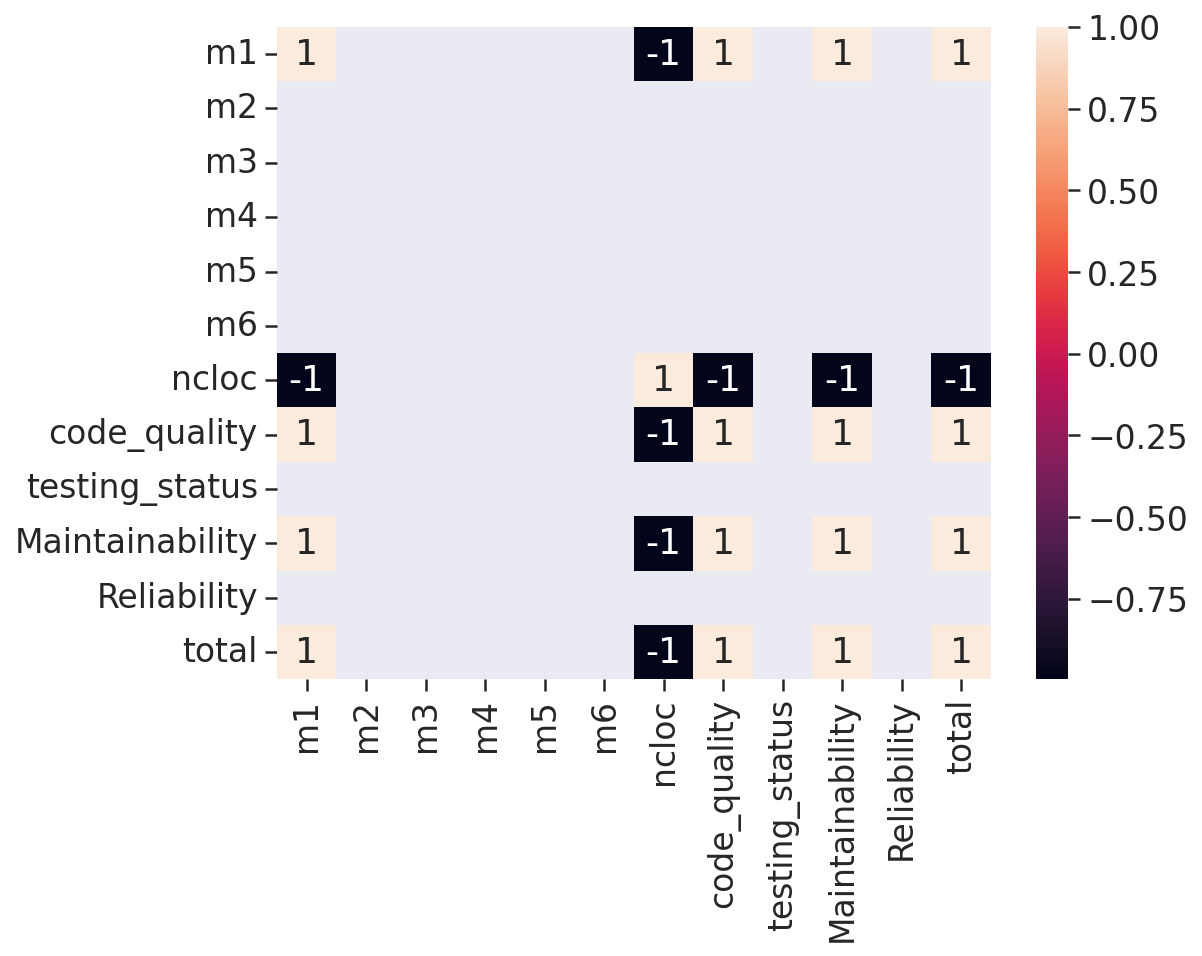

In [62]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Boxplot - Files

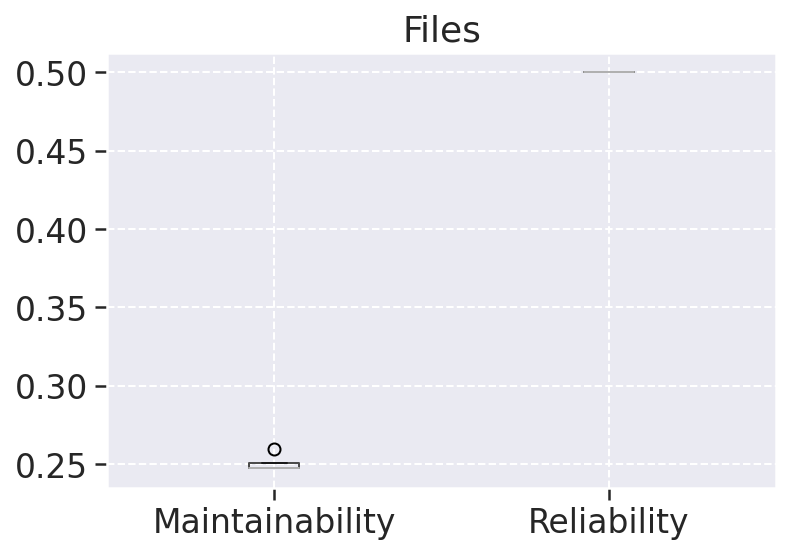

In [63]:
generate_box(generic_df, repository)
#generic_df

## Análise de  [Maintainability e Reliability] do repositório 2021_1-Multilind_Mobile_App

In [64]:
generic_df = mobile_app_metrics_df.sort_values('version')
repository = "Mobile_App"
generic_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
17,0.555556,0.0,1.0,1.0,1.0,1.0,Mobile_App,2021-09-14-03:28,50,0.513333,1.0,0.256667,0.5,0.756667
18,0.555556,0.0,1.0,1.0,1.0,1.0,Mobile_App,2021-09-27-03.13,50,0.513333,1.0,0.256667,0.5,0.756667
19,0.541176,0.0,1.0,1.0,1.0,1.0,Mobile_App,2021-10-19-18.47,2342,0.508588,1.0,0.254294,0.5,0.754294
20,0.541176,0.0,1.0,1.0,1.0,1.0,Mobile_App,2021-11-03-22:59,2222,0.508588,1.0,0.254294,0.5,0.754294
21,0.540230,0.0,1.0,1.0,1.0,1.0,Mobile_App,2021-11-08-20.15,2340,0.508276,1.0,0.254138,0.5,0.754138
22,0.544444,0.0,1.0,1.0,1.0,1.0,Mobile_App,2021-11-10-17.28,2439,0.509667,1.0,0.254833,0.5,0.754833


### Plot do Histórico das métricas - Mobile_App

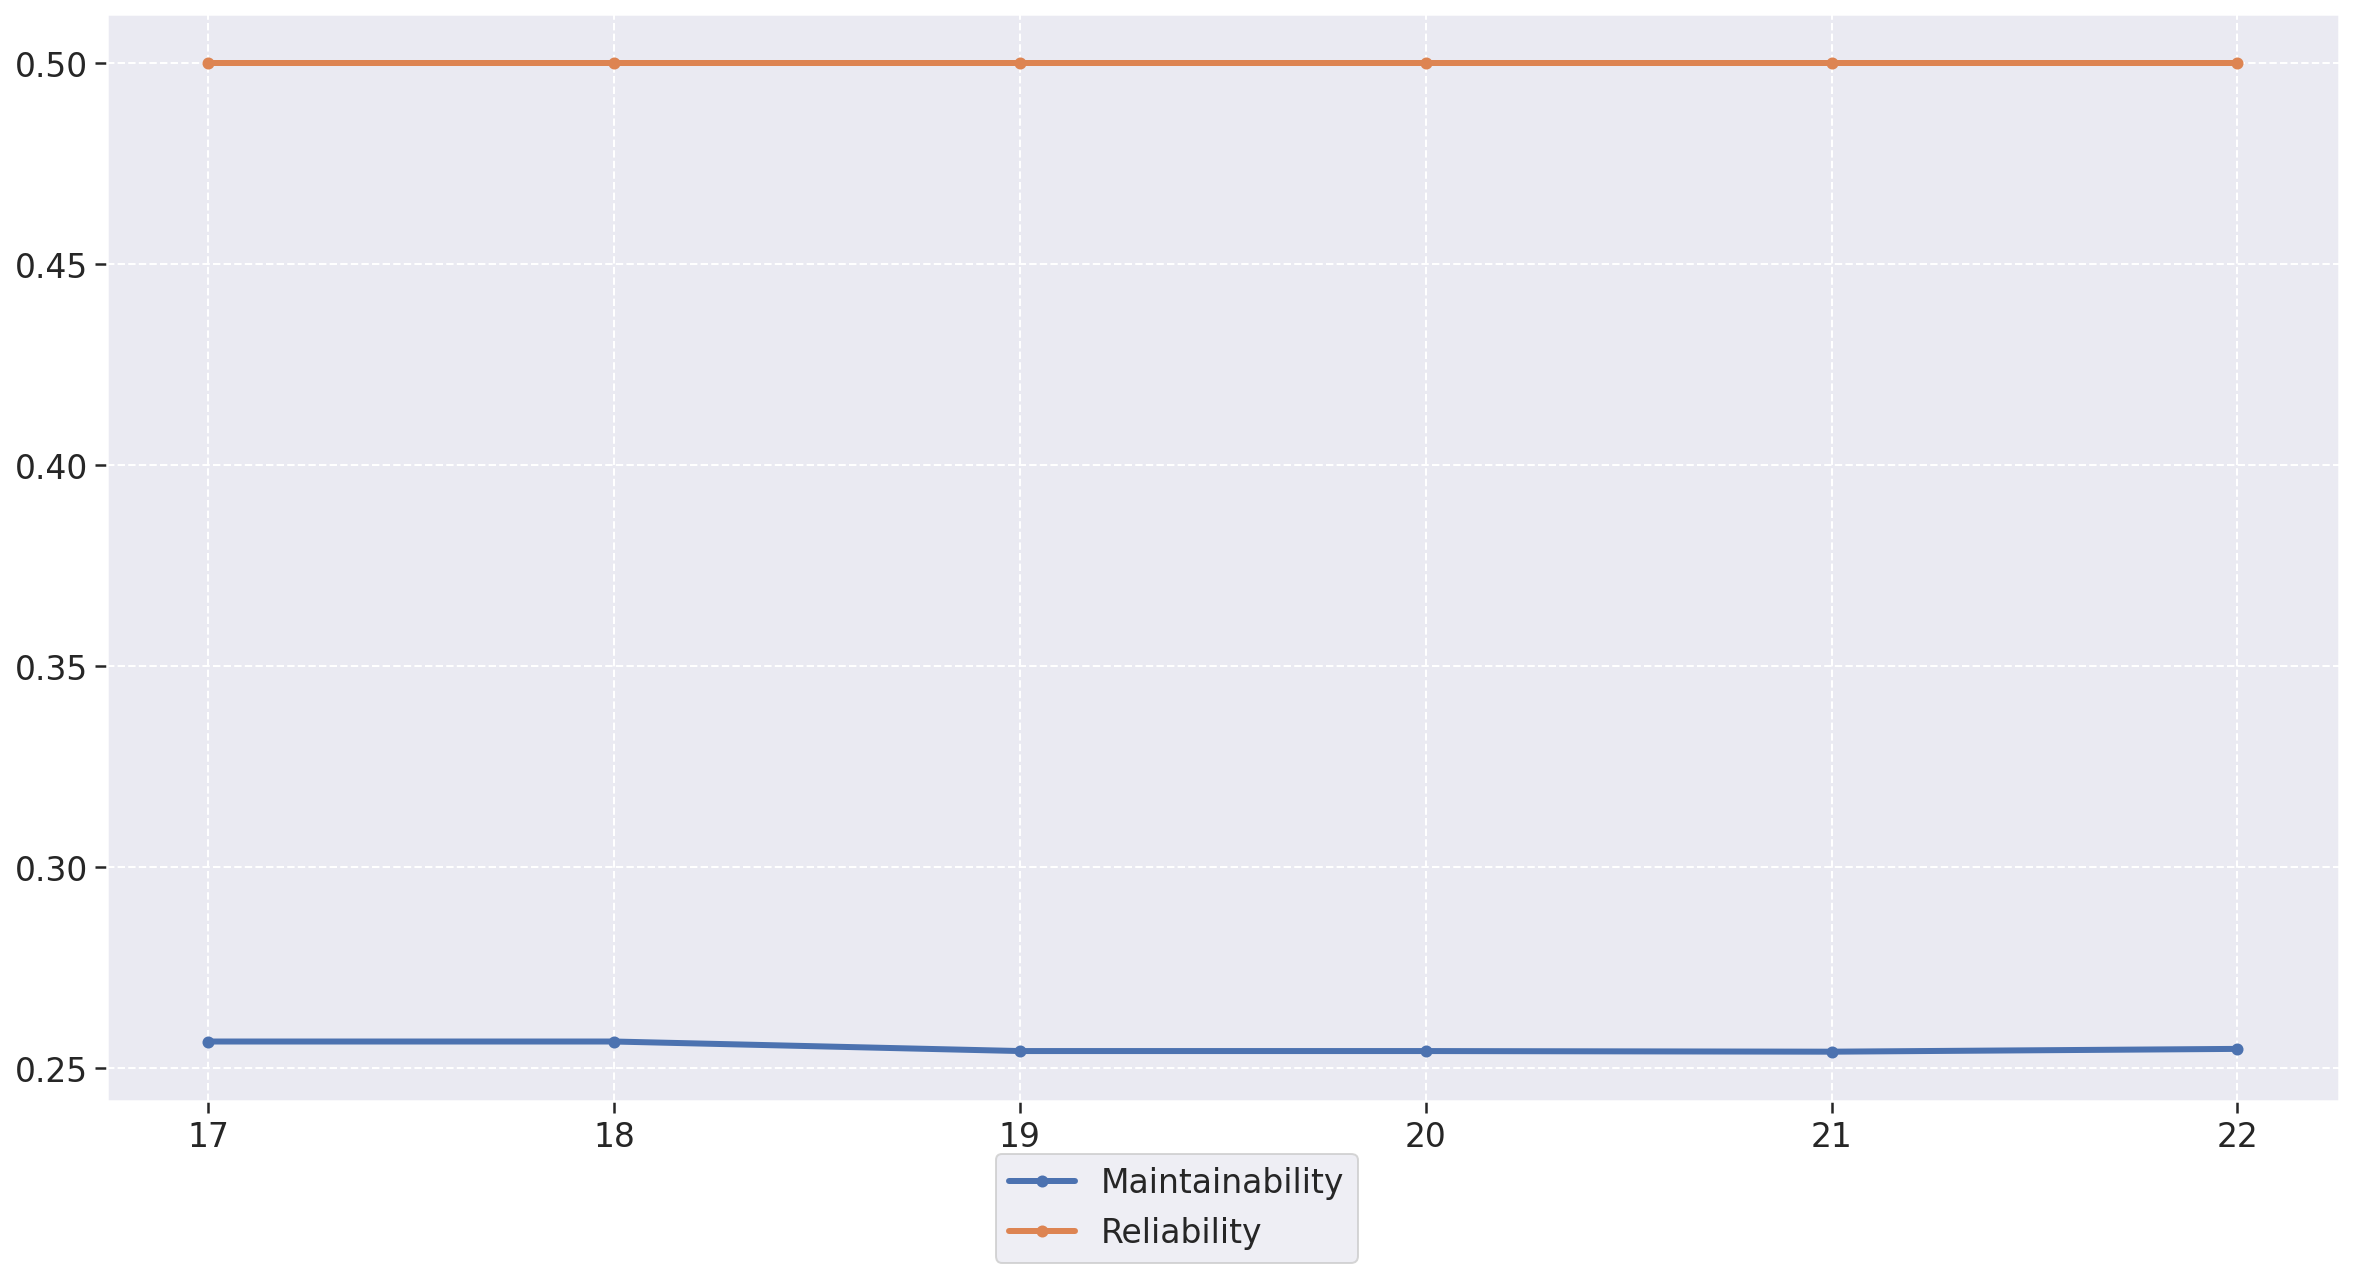

In [65]:
plot_history(generic_df, repository)

### Estatistica descritiva - Mobile_App

In [66]:
descriptive_statistics(generic_df)

/tmp/ipykernel_60612/3699529402.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median = df.median()
/tmp/ipykernel_60612/3699529402.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variance = df.var()


,count,mean,std,min,25%,50%,75%,max,var,median
m1,6.0,0.546356,0.007268,0.540230,0.541176,0.542810,0.552778,0.555556,5.282040e-05,0.542810
m2,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
m3,6.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000
m4,6.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000
m5,6.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000
m6,6.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000
ncloc,6.0,1573.833333,1182.358730,50.000000,593.000000,2281.000000,2341.500000,2439.000000,1.397972e+06,2281.000000
code_quality,6.0,0.510298,0.002398,0.508276,0.508588,0.509127,0.512417,0.513333,5.752142e-06,0.509127
testing_status,6.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000
Maintainability,6.0,0.255149,0.001199,0.254138,0.254294,0.254564,0.256208,0.256667,1.438036e-06,0.254564


### Cálculo da moda - Mobile_App

In [67]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.541176,0.0,1.0,1.0,1.0,1.0,50.0,0.508588,1.0,0.254294,0.5,0.754294
1,0.555556,NaN,NaN,NaN,NaN,NaN,NaN,0.513333,NaN,0.256667,NaN,0.756667


### Tabela de porcentagem - Mobile_App

In [68]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0%,0.540230,0.0,1.0,1.0,1.0,1.0,50.00,0.508276,1.0,0.254138,0.5,0.754138
10%,0.540703,0.0,1.0,1.0,1.0,1.0,50.00,0.508432,1.0,0.254216,0.5,0.754216
20%,0.541176,0.0,1.0,1.0,1.0,1.0,50.00,0.508588,1.0,0.254294,0.5,0.754294
30%,0.541176,0.0,1.0,1.0,1.0,1.0,1136.00,0.508588,1.0,0.254294,0.5,0.754294
40%,0.541176,0.0,1.0,1.0,1.0,1.0,2222.00,0.508588,1.0,0.254294,0.5,0.754294
50%,0.542810,0.0,1.0,1.0,1.0,1.0,2281.00,0.509127,1.0,0.254564,0.5,0.754564
60%,0.544444,0.0,1.0,1.0,1.0,1.0,2340.00,0.509667,1.0,0.254833,0.5,0.754833
70%,0.550000,0.0,1.0,1.0,1.0,1.0,2341.00,0.511500,1.0,0.255750,0.5,0.755750
80%,0.555556,0.0,1.0,1.0,1.0,1.0,2342.00,0.513333,1.0,0.256667,0.5,0.756667
99%,0.555556,0.0,1.0,1.0,1.0,1.0,2434.15,0.513333,1.0,0.256667,0.5,0.756667


### Matriz de correlação - Mobile_App

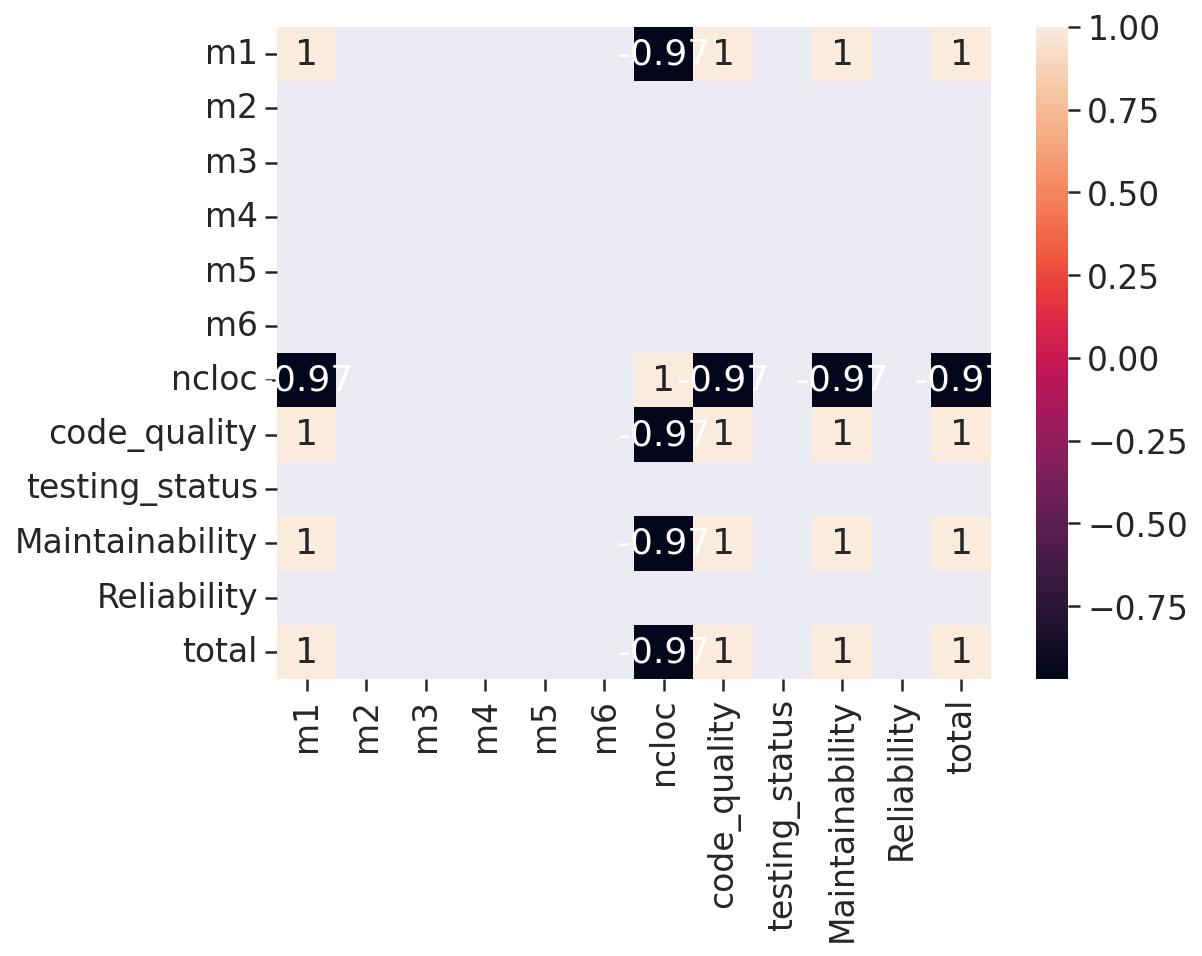

In [69]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Boxplot - Mobile_App

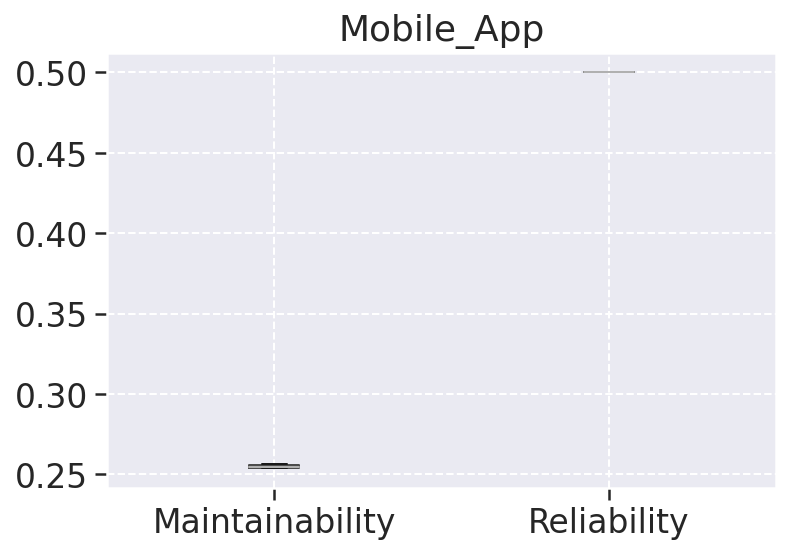

In [70]:
generate_box(generic_df, repository)
#generic_df

## Análise de  [Maintainability e Reliability] de todos os repositórios

In [71]:
generic_df = metrics_df.sort_values('version')
repository = "All repositories"
generic_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
3,0.625000,0.000000,1.000000,1.000000,1.000000,1.000000,User,2021-09-14-03:28,70,0.536250,1.000000,0.268125,0.500000,0.768125
7,0.714286,0.000000,0.892857,0.892857,0.892857,0.892857,Content,2021-09-14-03:28,629,0.530357,0.892857,0.265179,0.446429,0.711607
17,0.555556,0.000000,1.000000,1.000000,1.000000,1.000000,Mobile_App,2021-09-14-03:28,50,0.513333,1.000000,0.256667,0.500000,0.756667
13,0.571429,0.000000,1.000000,1.000000,1.000000,1.000000,Files,2021-09-14-03:28,54,0.518571,1.000000,0.259286,0.500000,0.759286
4,0.625000,0.000000,1.000000,1.000000,1.000000,1.000000,User,2021-09-27-02.31,70,0.536250,1.000000,0.268125,0.500000,0.768125
18,0.555556,0.000000,1.000000,1.000000,1.000000,1.000000,Mobile_App,2021-09-27-03.13,50,0.513333,1.000000,0.256667,0.500000,0.756667
8,0.711538,0.000000,0.942308,0.942308,0.942308,0.942308,Content,2021-09-27-03.22,1323,0.545769,0.942308,0.272885,0.471154,0.744038
9,0.723077,0.000000,0.969231,0.969231,0.969231,0.969231,Content,2021-10-06-19.24,1879,0.558462,0.969231,0.279231,0.484615,0.763846
14,0.500000,0.000000,1.000000,1.000000,1.000000,1.000000,Files,2021-10-15-19.42,125,0.495000,1.000000,0.247500,0.500000,0.747500
15,0.500000,0.000000,1.000000,1.000000,1.000000,1.000000,Files,2021-10-15-20.05,125,0.495000,1.000000,0.247500,0.500000,0.747500


### Plot do Histórico das métricas - All Repositories

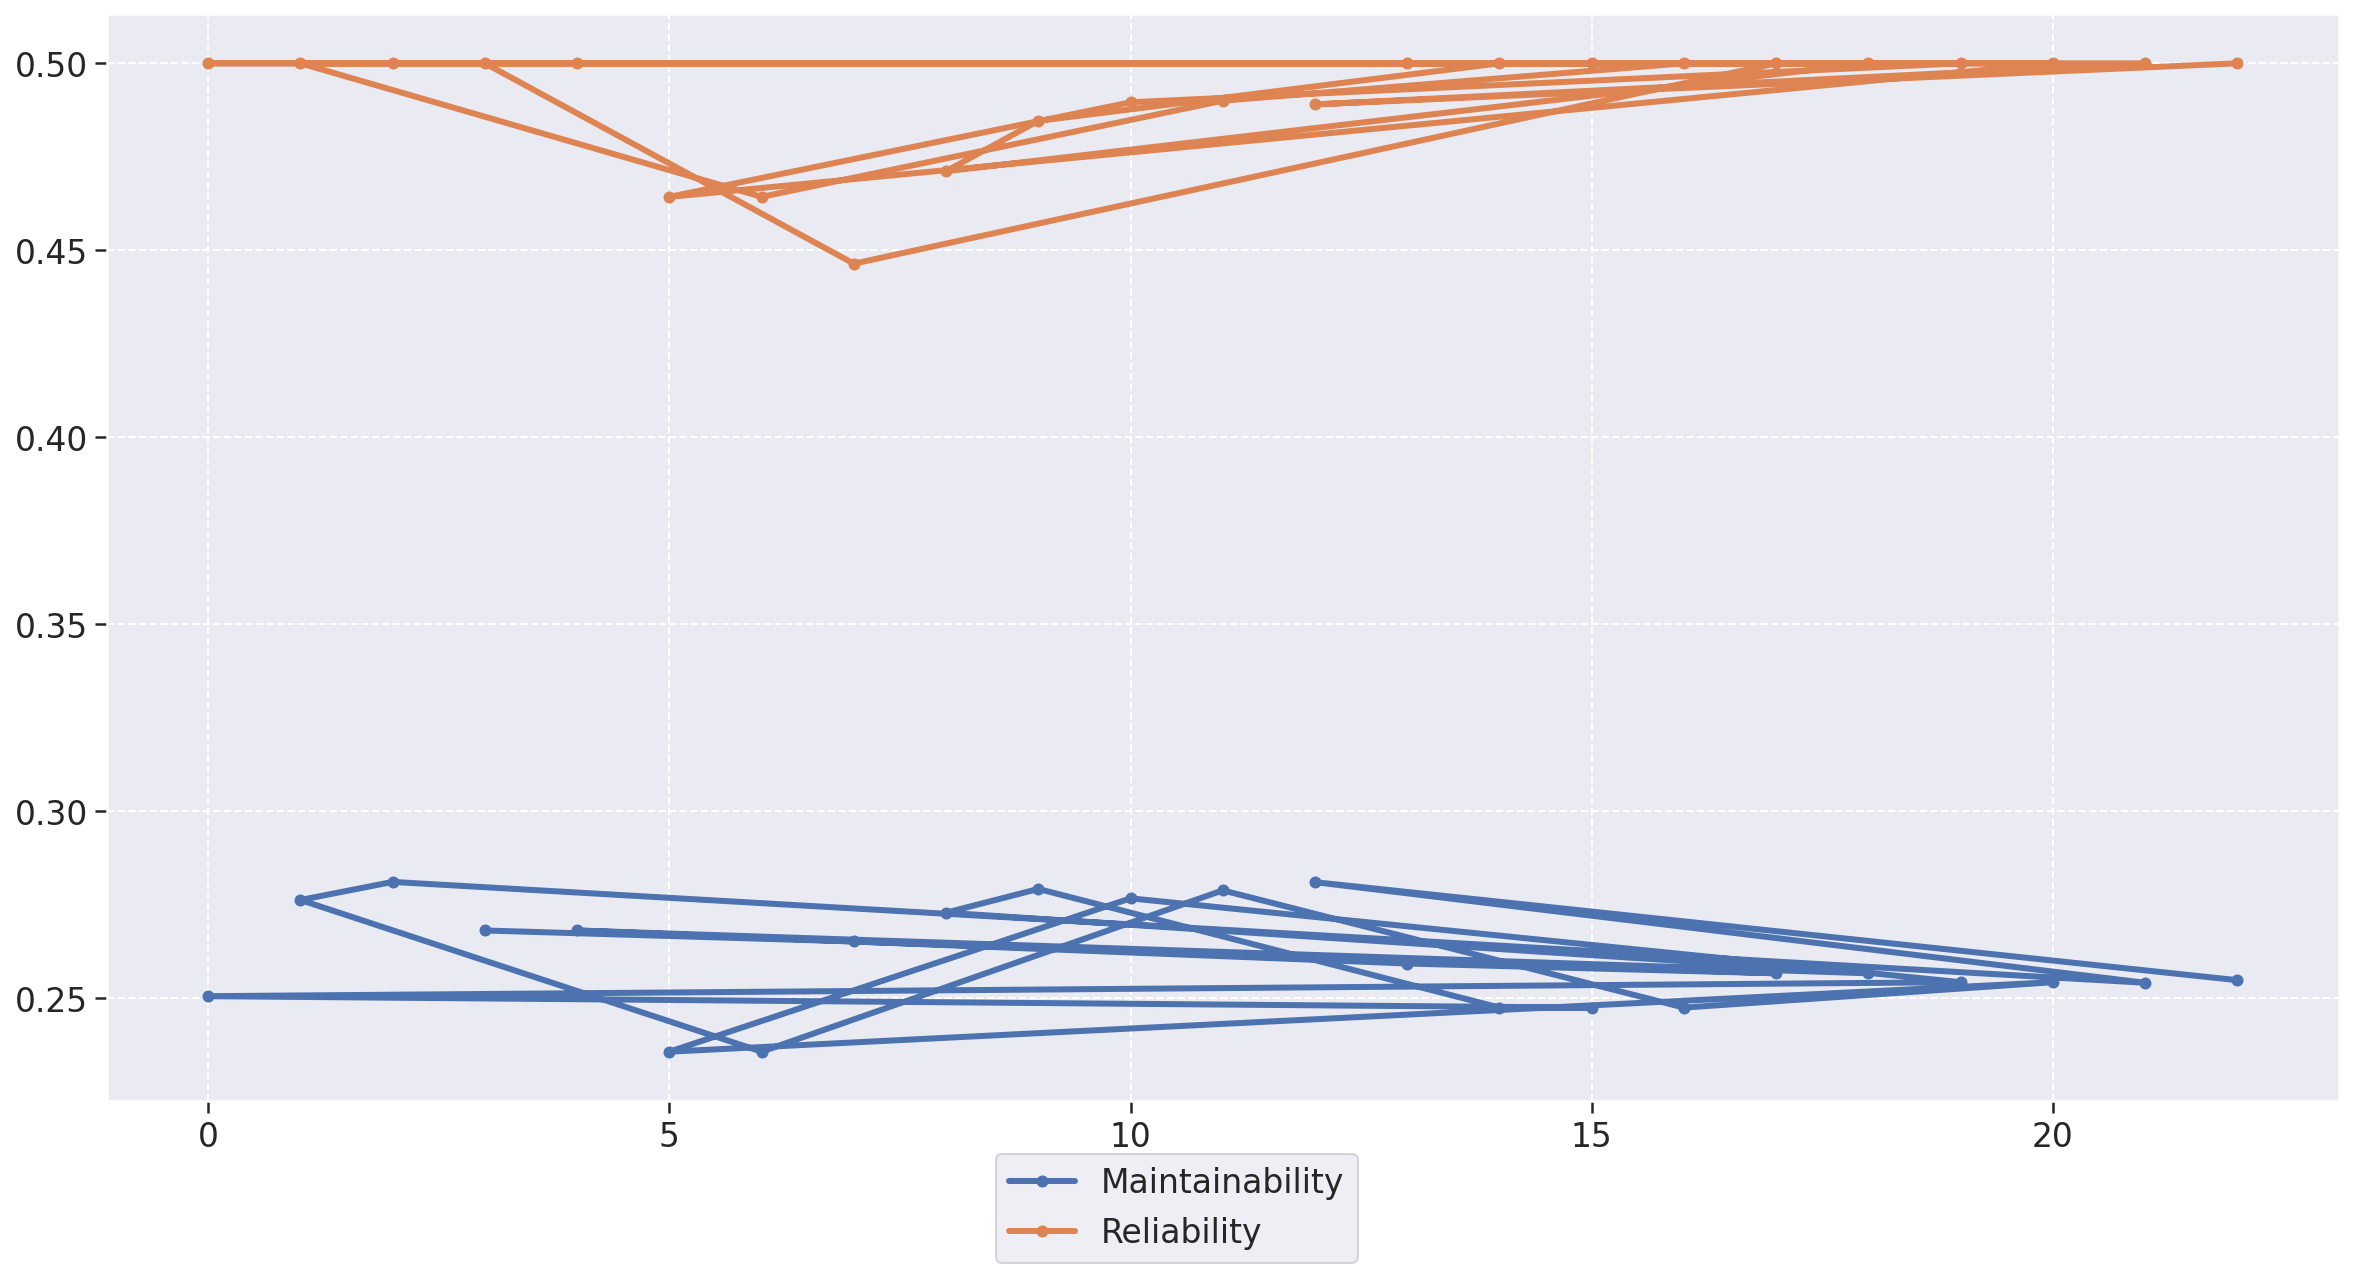

In [72]:
plot_history(generic_df, repository)

### Estatistica descritiva - All Repositories

In [73]:
descriptive_statistics(generic_df)

/tmp/ipykernel_60612/3699529402.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median = df.median()
/tmp/ipykernel_60612/3699529402.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variance = df.var()


,count,mean,std,min,25%,50%,75%,max,var,median
m1,23.0,0.598101,0.086721,0.500000,0.529374,0.555556,0.700607,0.723077,0.007521,0.555556
m2,23.0,0.000956,0.004583,0.000000,0.000000,0.000000,0.000000,0.021978,0.000021,0.000000
m3,23.0,0.982553,0.030358,0.892857,0.978594,1.000000,1.000000,1.000000,0.000922,1.000000
m4,23.0,0.982553,0.030358,0.892857,0.978594,1.000000,1.000000,1.000000,0.000922,1.000000
m5,23.0,0.982553,0.030358,0.892857,0.978594,1.000000,1.000000,1.000000,0.000922,1.000000
m6,23.0,0.982553,0.030358,0.892857,0.978594,1.000000,1.000000,1.000000,0.000922,1.000000
ncloc,23.0,1063.739130,988.842952,50.000000,125.000000,688.000000,2130.000000,2647.000000,977810.383399,688.000000
code_quality,23.0,0.521931,0.028117,0.471429,0.504693,0.513333,0.549164,0.562222,0.000791,0.513333
testing_status,23.0,0.982553,0.030358,0.892857,0.978594,1.000000,1.000000,1.000000,0.000922,1.000000
Maintainability,23.0,0.260966,0.014058,0.235714,0.252347,0.256667,0.274582,0.281111,0.000198,0.256667


### Cálculo da moda - All Repositories

In [74]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.5,0.0,1.0,1.0,1.0,1.0,50,0.495,1.0,0.2475,0.5,0.7475
1,NaN,NaN,NaN,NaN,NaN,NaN,70,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,125,NaN,NaN,NaN,NaN,NaN


### Tabela de porcentagem - All Repositories

In [75]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0%,0.500000,0.000000,0.892857,0.892857,0.892857,0.892857,50.0,0.471429,0.892857,0.235714,0.446429,0.700000
10%,0.500000,0.000000,0.931319,0.931319,0.931319,0.931319,57.2,0.495000,0.931319,0.247500,0.465659,0.718093
20%,0.507407,0.000000,0.972747,0.972747,0.972747,0.972747,92.0,0.497444,0.972747,0.248722,0.486374,0.747500
30%,0.540798,0.000000,0.979667,0.979667,0.979667,0.979667,129.2,0.508463,0.979667,0.254232,0.489833,0.749333
40%,0.543791,0.000000,1.000000,1.000000,1.000000,1.000000,567.6,0.509451,1.000000,0.254725,0.500000,0.754263
50%,0.555556,0.000000,1.000000,1.000000,1.000000,1.000000,688.0,0.513333,1.000000,0.256667,0.500000,0.754833
60%,0.625000,0.000000,1.000000,1.000000,1.000000,1.000000,1105.4,0.531536,1.000000,0.265768,0.500000,0.757190
70%,0.683818,0.000000,1.000000,1.000000,1.000000,1.000000,1942.6,0.540058,1.000000,0.270029,0.500000,0.764829
80%,0.703541,0.000000,1.000000,1.000000,1.000000,1.000000,2292.8,0.553086,1.000000,0.276543,0.500000,0.768125
99%,0.721143,0.017143,1.000000,1.000000,1.000000,1.000000,2609.6,0.562193,1.000000,0.281096,0.500000,0.780048


### Matriz de correlação - All Repositories

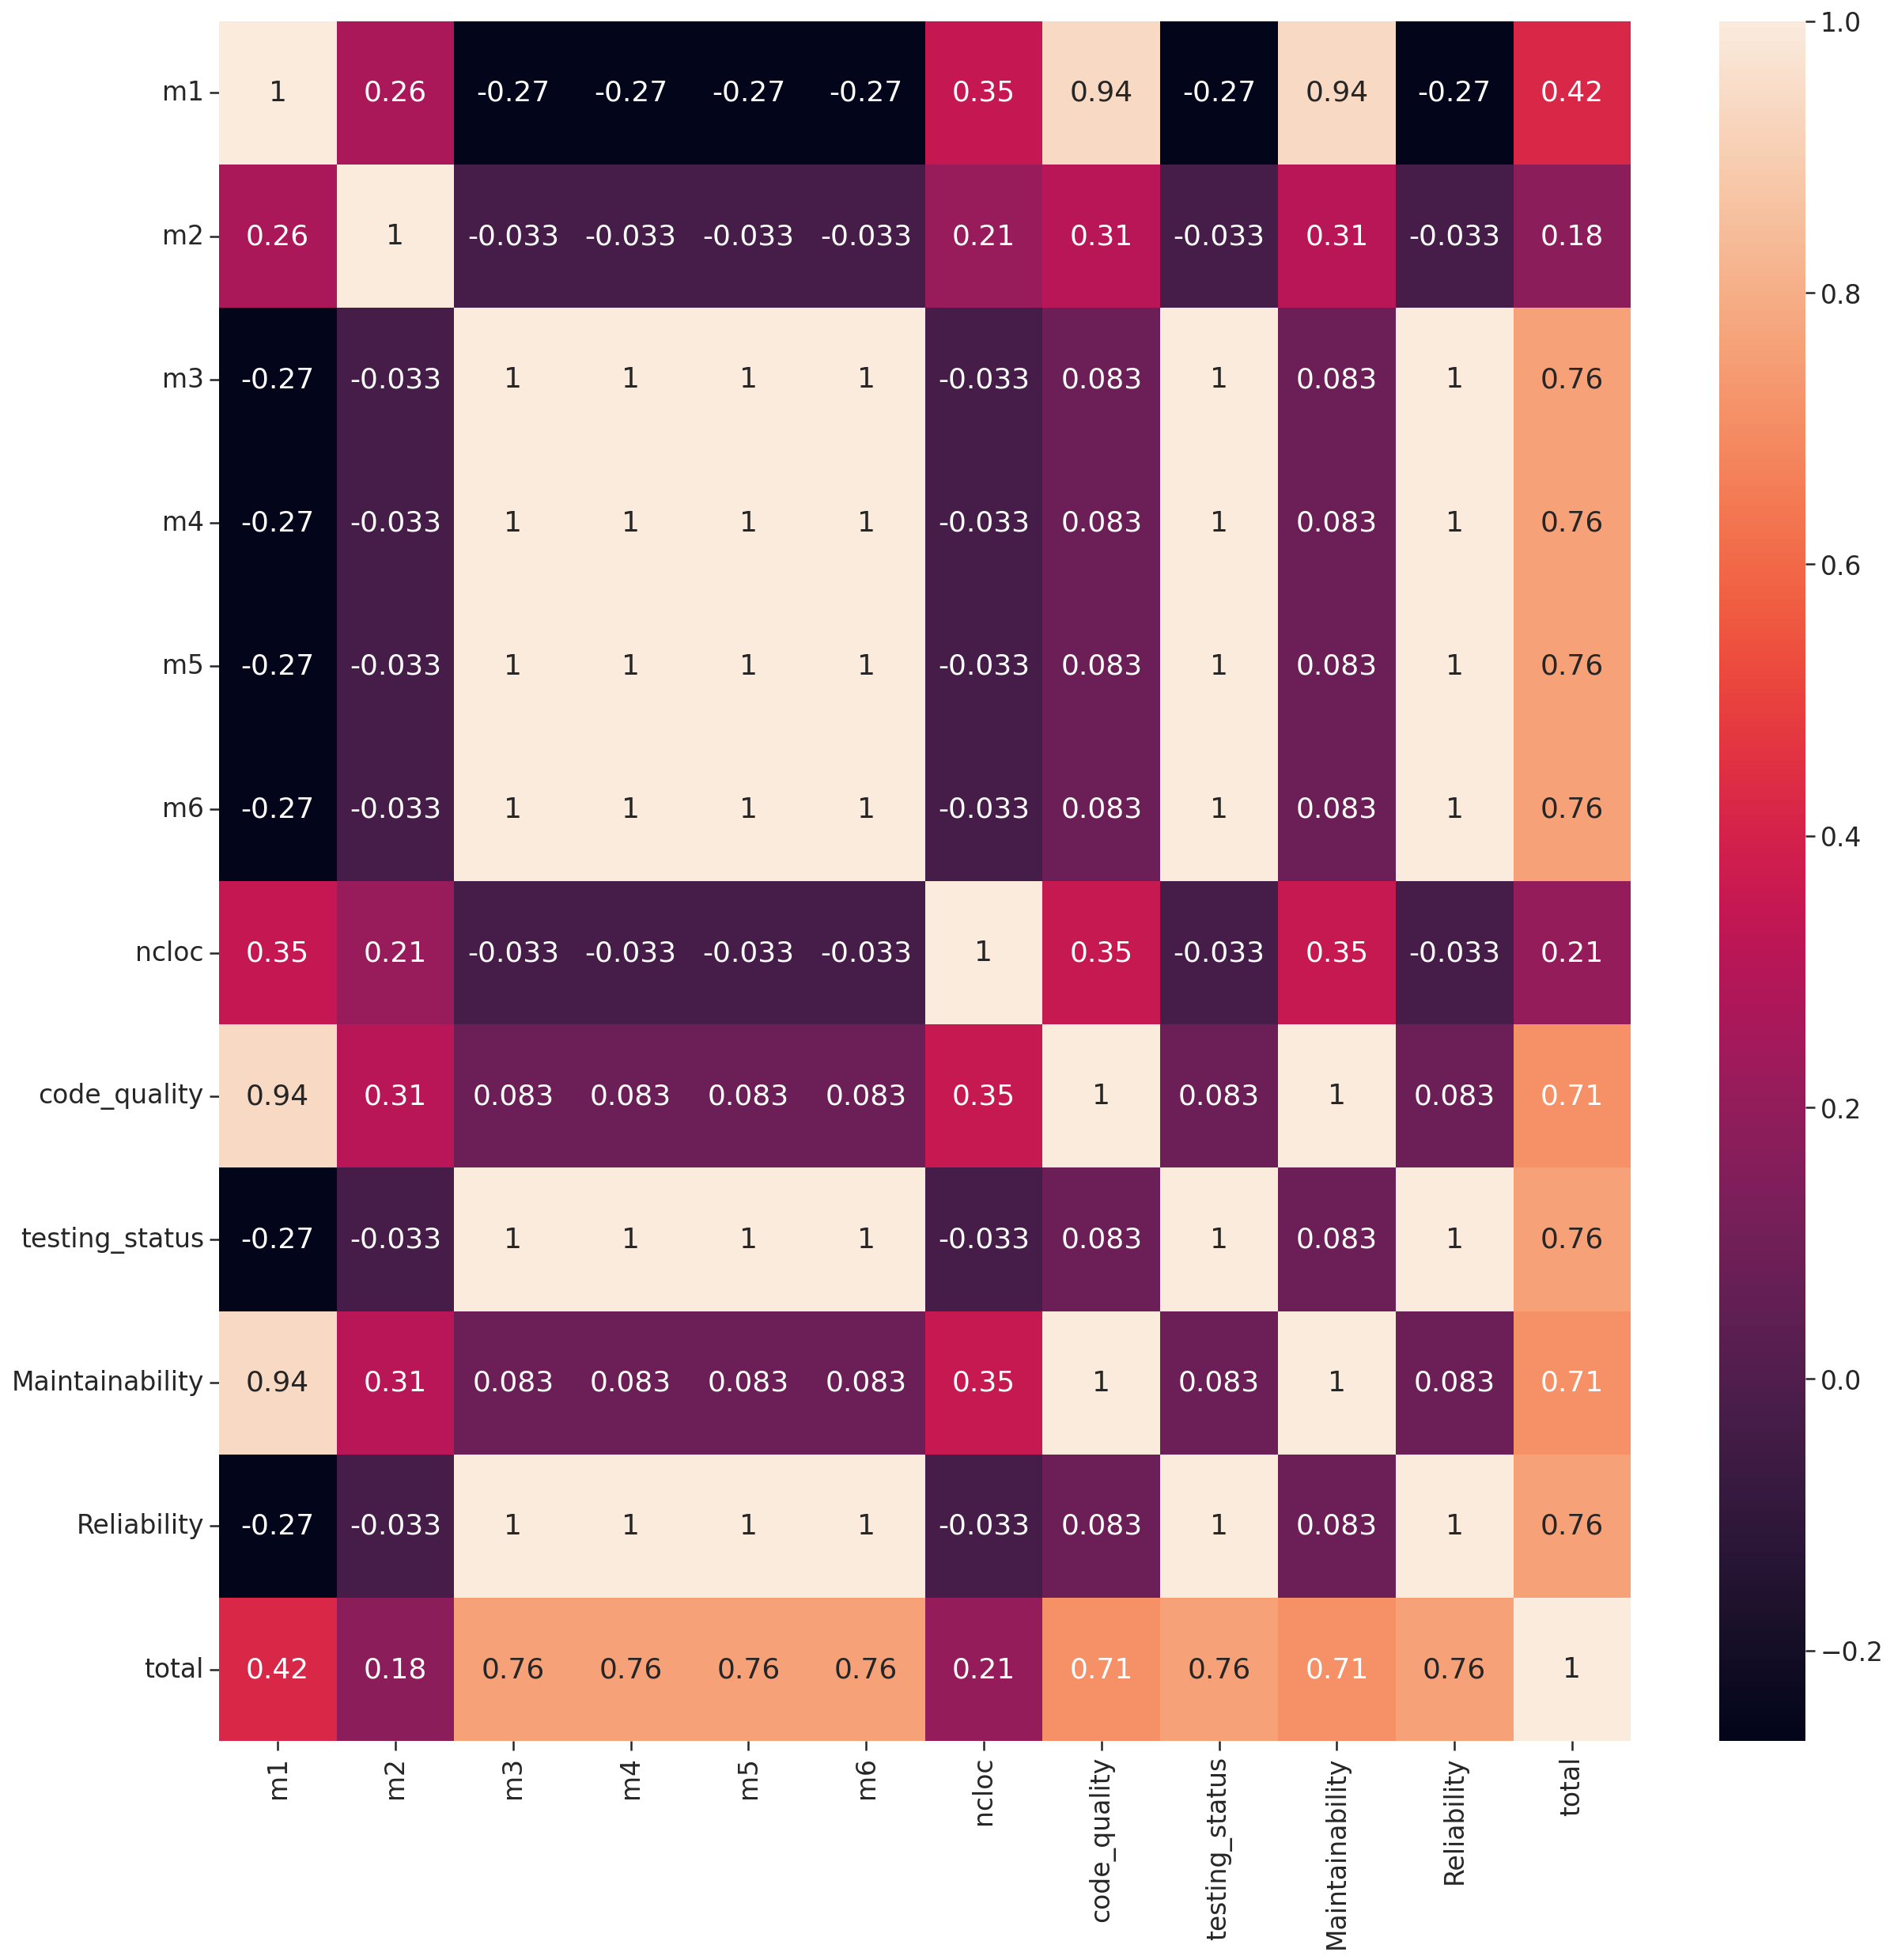

In [76]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Boxplot - All Repositories

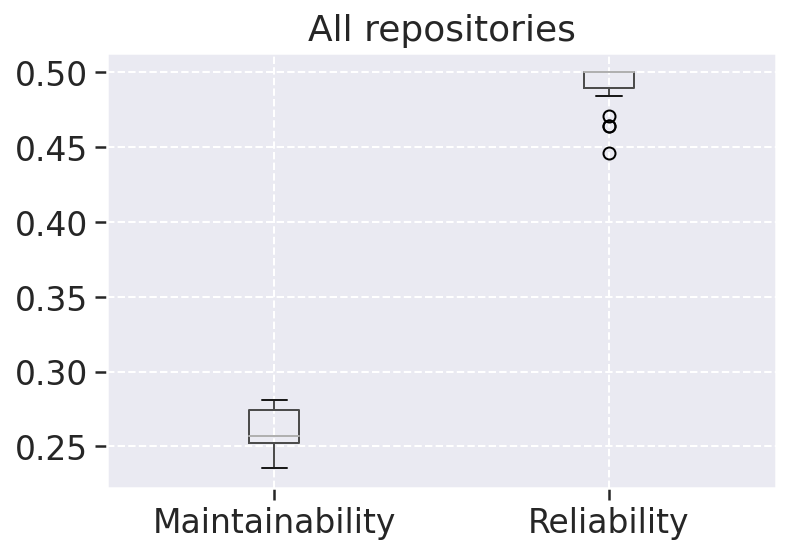

In [77]:
generate_box(generic_df, repository)
#generic_df

In [78]:
# ANALYSIS_DATE FORMAT: MM-DD-YYYY
fix_metrics_df = metrics_df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'Maintainability', 'Reliability', 'total', 'ncloc', 'repository', 'version', 'version']]
fix_metrics_df.columns = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'Maintainability', 'Reliability', 'Total_QR', 'LOC', 'Repository', 'Version', 'Data']

fix_metrics_df.to_excel('data/fga-eps-mds-2021_1-Multilind-ANALYSYS.xlsx', index = False)
fix_metrics_df.to_csv('data/fga-eps-mds-2021_1-Multilind-ANALYSYS.csv', index = False)

# Gráfico de Dispersão - Qualidade total

- O gráfico de dispersão mostra a correlação entre duas váriaveis e como elas se afetam, aqui os pares de dados que relacionaremos serão Manutenibilidade x Confiabilidade. Tanto a métrica de confiabilidade quanto a de manutenibilidade são métricas de qualidade de software definidas no Q-Rapids, e elas nos ajudam a definir aspectos de qualidade externa e interna do produto e fazem parte do modelo de qualidade, além disso, temos também sub-aspectos em cada uma dessas características principais. Cada uma dessas métricas indicam alguns aspectos do nosso produto e iremos abordá-los mais a fundo para uma melhor compreensão do nosso gráfico de dispersão.

- Manutenibilidade (Maintainability): Essa métrica nos diz respeito a capacidade do produto de software de ser modificado. As modificações podem incluir correções, melhorias ou adaptações. Usando as métricas m1, m2, m3, fizemos um cálculo da manutenibilidade dos repositórios do projeto afim de compararmos com a métrica de confiabilidade. As métricas m1, m2 e m3 correspondem a qualidade de código estático. 

- Confiabilidade (Reliability): Capacidade do produto de software de manter um nível de desempenho especificado, quando usado em condições especificadas. Usando as métricas m4, m5, m6, fizemos um cálculo da confiabilidade dos repositórios do projeto afim de compararmos com a métrica de manutenibilidade. As métricas m4, m5 e m6 correspondem a qualidade de testes.

## Interpretando o Gráfico de Dispersão

Com base nas definições citadas acima podemos então interpretar o gráfico de dispersão dos aspectos de qualidade citados acerca dos repositórios do projeto, esse gráfico plota os pontos de qualidade de todos os repositórios e correlaciona manutenibilidade x confiabilidade além de nos mostrar uma barra lateral que indica a qualidade total. Esse gráfico tem escala que vai de 0 a 1 sendo 0 nenhuma qualidade e 1 qualidade máxima. 

Podemos observar que o projeto não conseguiu atingir o nível um de qualidade das métricas citadas porém chegou em um bom valor de pouco mais de 0.77, podemos ver também que quanto mais a manutenibilidade cresce, mais cresce a confiabilidade do projeto o que também acarreta uma subida no aspecto de qualidade geral.

Apesar de não termos conseguido chegar a uma qualidade máxima ao decorrer do projeto a qualidade foi melhorando e isso decorre de uma maior cobertura de testes e também de uma melhor implementação de código e diminuição de complexidade.


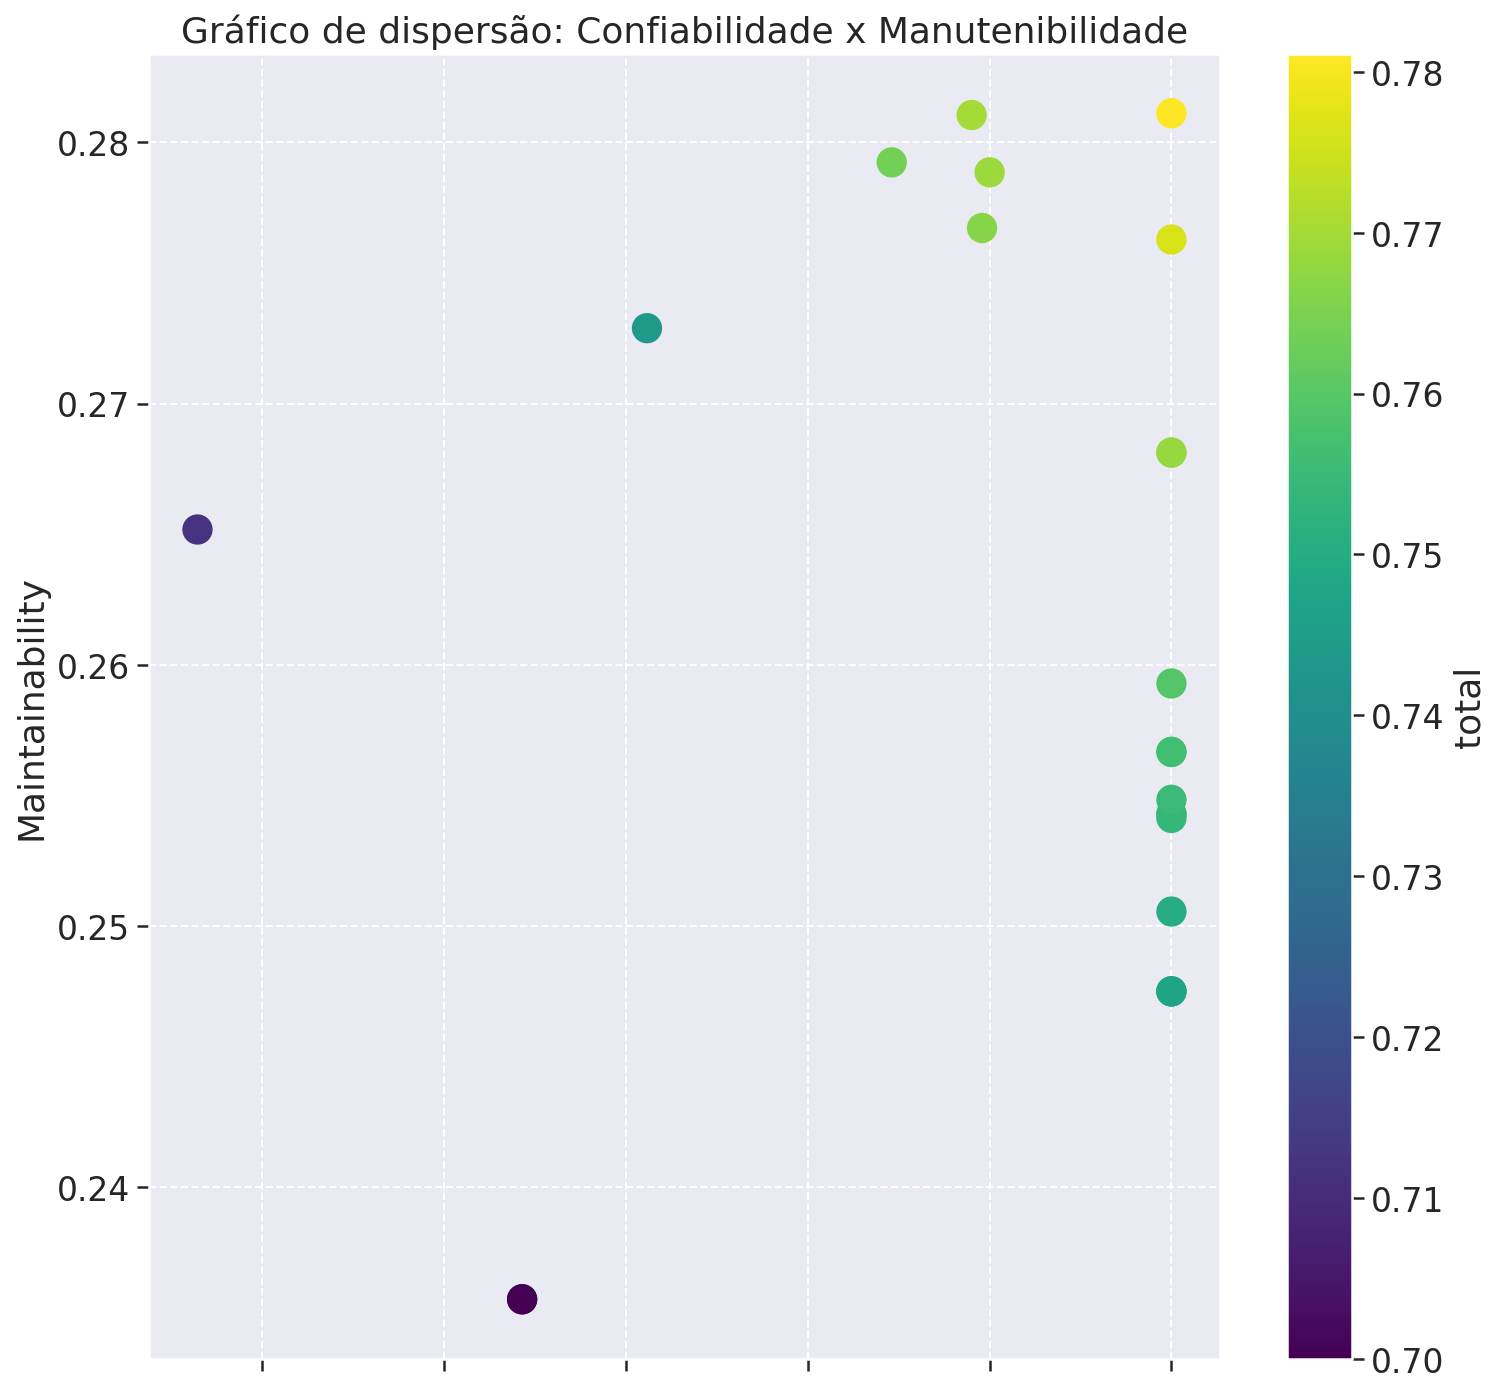

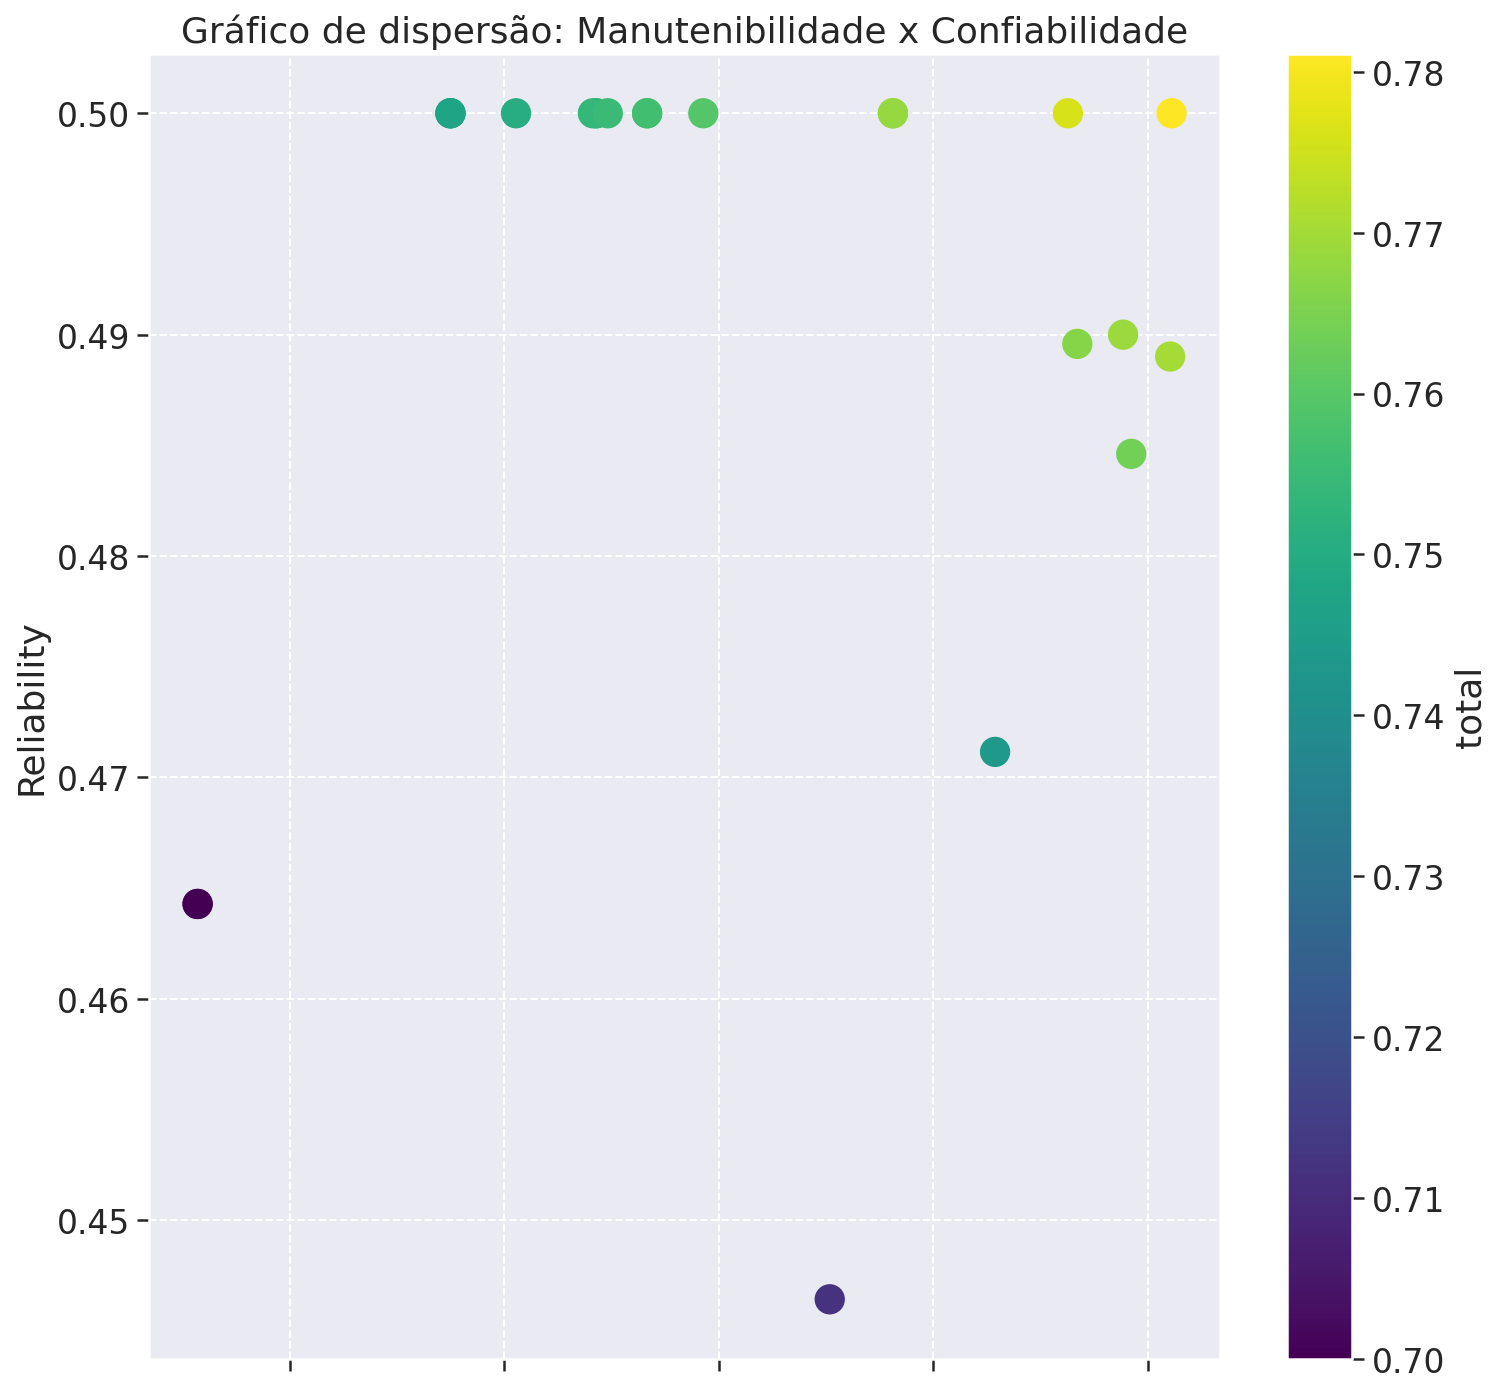

In [85]:
dataFrame = pd.DataFrame(data=metrics_df, columns=['Maintainability','Reliability', 'total']);
dataFrame.plot.scatter(x='Reliability', y='Maintainability', title= "Gráfico de dispersão: Confiabilidade x Manutenibilidade", c='total', s=200,colormap='viridis', figsize=(12, 12));
dataFrame.plot.scatter(x='Maintainability', y='Reliability', title= "Gráfico de dispersão: Manutenibilidade x Confiabilidade", c='total', s=200,colormap='viridis', figsize=(12, 12));
#fig = plt.figure(figsize=(20, 10))
#plt.show(block=True)

# Gráfico de Histograma

O gráfico de histograma mostra a ocorrência de um determinado valor em um determinado intervalo, um exemplo fácil para se entender um gráfico de histograma e plotar um gráfico de número de jogadores de futebol de um time x Idade, ou seja, esses dados em um gráfico de histograma nos mostram a quantidade de jogadores de uma determinada idade. 

No nosso projeto usaremos esse gráfico para plotar o ocorrência das métricas de qualidade do nosso dataset final, afim de analisarmos a Manutenibilidade e a Confiabilidade do nosso projeto, como todas as métricas ocorrem no intervalo de 0 a 1 sendo 0 nenhuma qualidade, e 1 a maior qualidade possível.

As métricas analisadas são as métricas de m1 a m6, Maintainability, Reliability e total, a última representa um valor de qualidade de cada release de cada repositório com base nas métricas citadas anteriormente.

## Interpretando os gráficos de histograma da cada métrica.

**m1**: A m1, ou métrica 1, diz respeito a a complexidade do código que diz respeito a quantidade de caminhos independentes ou ciclos encontrados em um código, esse gráfico corresponde a ocorrencia da m1 em todos os repositórios, é possível notar que essa métrica tem sua maior ocorrência no valor de 0.5 com um total de 6 aparições, ou seja, um pouco abaixo da média. 

**m2**: A m2, ou métrica dois, é a densidade de arquivos comentados, essa métrica conta o número de linhas comentadas no código. É possível notar que não temos linhas de código comentadas, e a maior ocorrência se dá no valor 0. 

**m3**: A métrica 3, ou m3, é duplicated_lines_density e diz respeito a quantidade de linhas de código duplicadas, aqui temos a maior ocorrência dessa métrica em 1 com poucos mais de 12 ocorrências, o que é um bom indicador de que nosso código tem um baixo nível de acoplamento e um alto nível de coesão, o que é muito bom pois isso incrementa a métrica de manutenibilidade diretamente.

**m4:** A métrica 4, ou m4, é test_success_density, ou seja é a densidade de testes unitários executados com sucesso, essa métrica no nosso projeto se saiu bem pois no geral os valores se aproximam muito de 1 o que é um bom indicador que os testes foram bem executados e rodaram conforme o esperado. 

**m5:** A m5, ou métrica 5, diz respeito ao tempo de execução de testes unitários e também se saiu bem com seu valores se aproximando de um, de fato os testes são executados de maneira bem rápida e eficiente.

**m6:**  A métrica 6 diz respeito ao coverage e também tem sua maior ocorrência em 1, entretanto essa métrica apenas observada dessa forma não se aproxima muito bem da realidade tendo em vista que ela olha todos os arquivos com extensão js, e não necessáriamente todos esses arquivos precisam ser testados ou são código de funcionalidade, nossa cobertura de testes atinge 90% nos repositórios de Content e User.

**Manutenibilidade:** Métrica de qualidade médida pelo sonarqube com base nas outras métricas coletadas e que estão disponíveis nos jsons, ela leva em conta os code_smells e outros, é possível observar que essa métrica tem seu maior índice de ocorrência em 0.255 e 0.28, o que mostra que a maiora das ocorrências tem nota D, o que não é muito bom porém também existe margem de erro para esses dados e conseguiriamos melhorar essas métricas eliminando code smells, diminuido linhas de comentários etc.

**Confiabilidade:** A métrica de confiailidade tem sua maior ocorrência em 0.5 o que não é a melhor possível entretanto está na média, ela ocorre devido a bugs e aumenta conforme a gravidade do bug e outros, não temos nenhum bug critico entretanto temos bugs menores que fazem nossa confiabilidade cair.

**total:** A métrica total indica a qualidade total de todo o projeto levando em conta as métricas citadas, ela tem sua maior ocorrência em 0.76, é um bom valor e nos demonstra apenas o que já foi dito pela junção das outras métricas, algumas estão muito bem, outras nem tanto e no total nenhum repositório atingiu níveis de qualidade maiores ou iguais a 1.

<Figure size 1440x288 with 0 Axes>

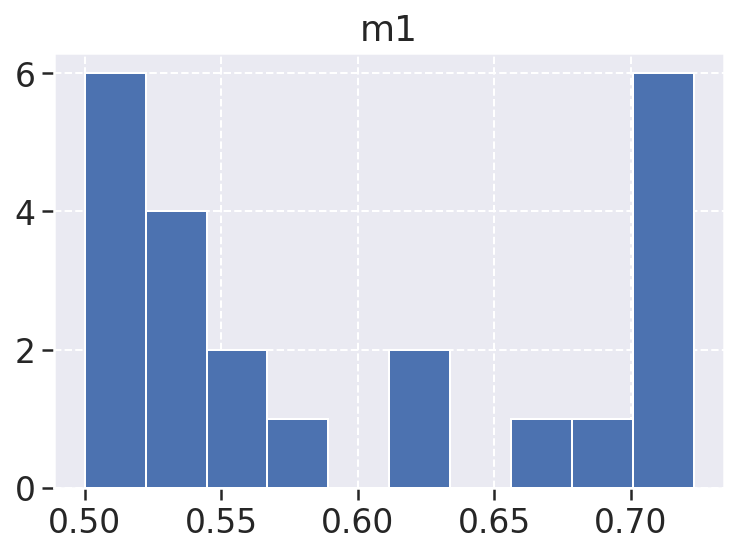

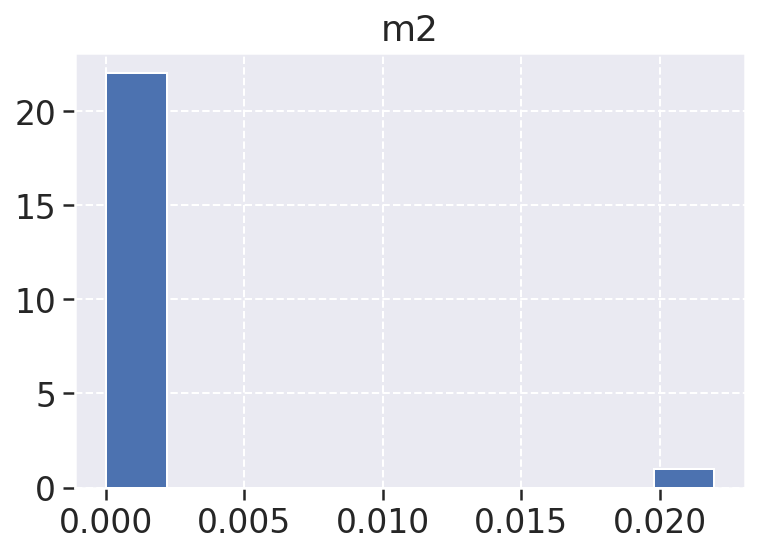

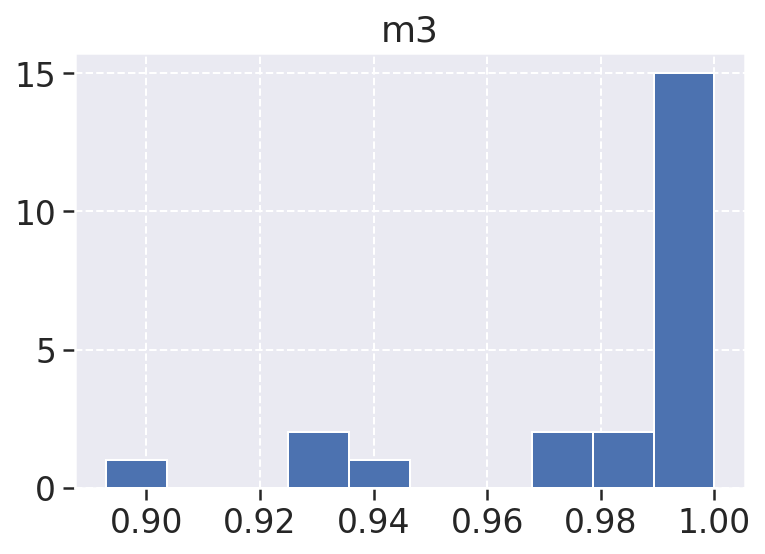

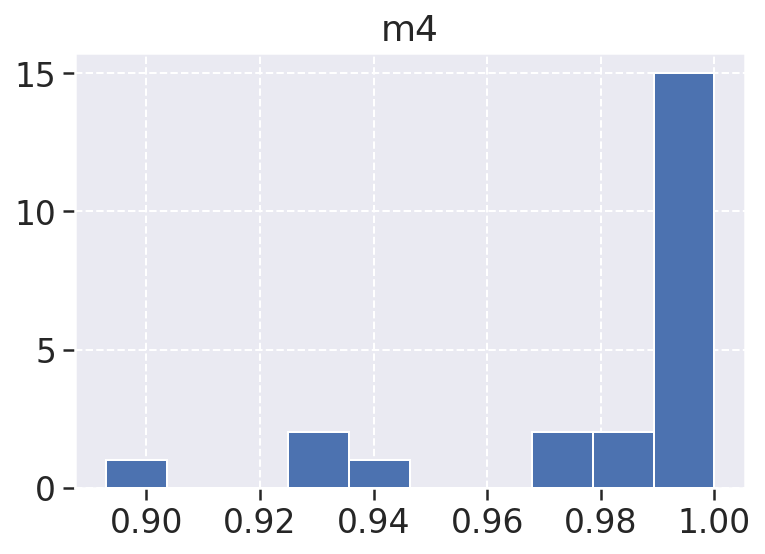

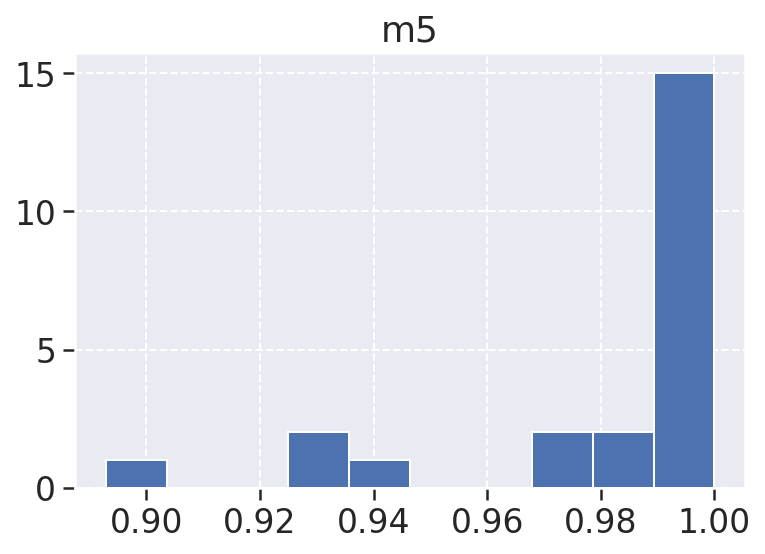

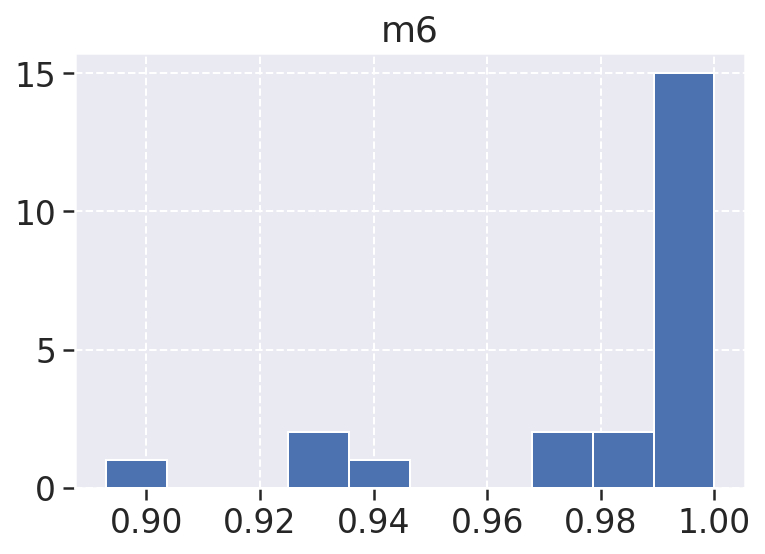

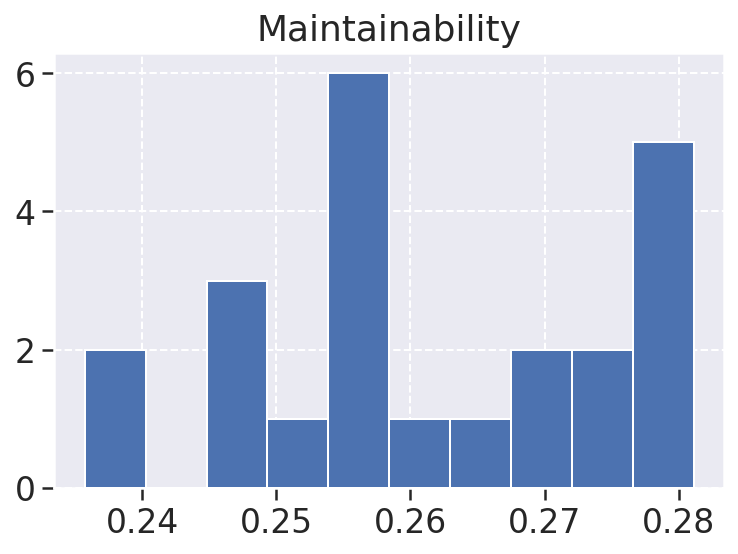

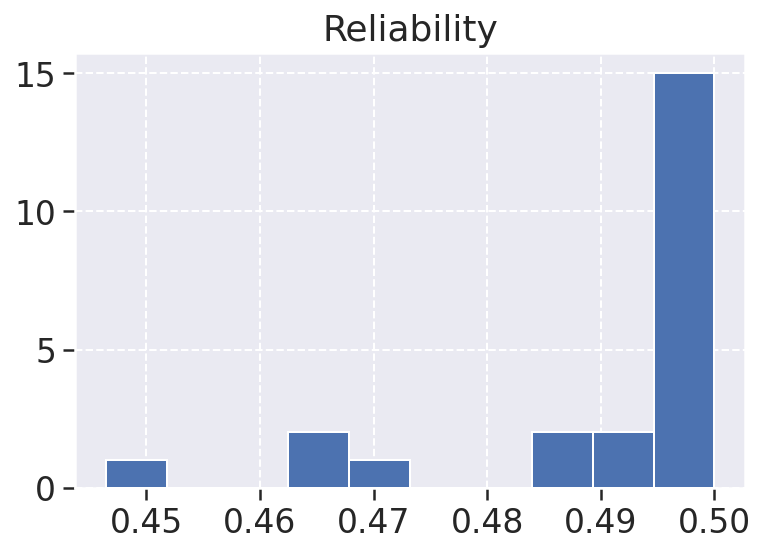

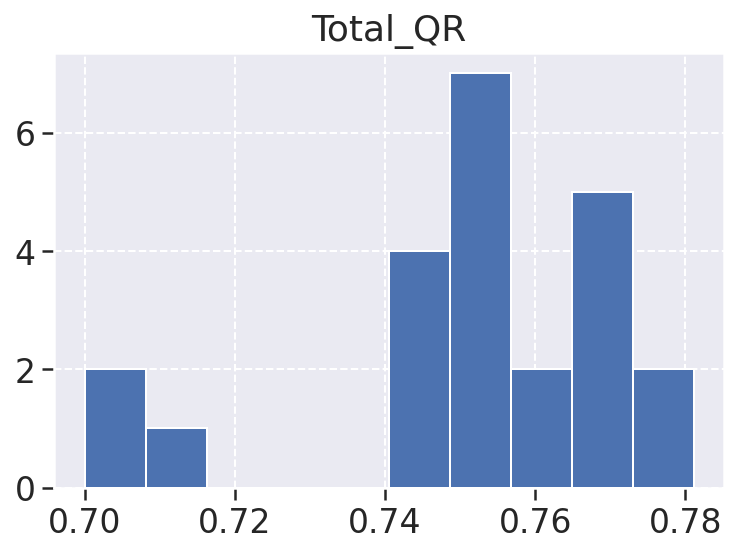

In [86]:
plt.figure(figsize=(20, 4))

url= 'data/fga-eps-mds-2021_1-Multilind-ANALYSYS.xlsx'
df= pd.read_excel(url)
df.head()

df.hist(column='m1')
df.hist(column='m2')
df.hist(column='m3')
df.hist(column='m4')
df.hist(column='m5')
df.hist(column='m6')
df.hist(column='Maintainability')
df.hist(column='Reliability')
df.hist(column='Total_QR')
plt.show()